<a href="https://colab.research.google.com/github/julietlawton/image-captioning/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning

## Setup

In [ ]:
# Install croissant
!pip install -q mlcroissant

from mlcroissant import Dataset

In [1]:
# Import modules
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time
import textwrap
import os
import random
import ast
import re

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from concurrent.futures import ThreadPoolExecutor
from nltk.tokenize import word_tokenize
from PIL import Image
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Load Dataset

In [3]:
# Define a global variable that determines how to load the dataset
USE_CROISSANT = False

# Get the device for this session
devices = tf.config.list_physical_devices('GPU')
device_name = tf.config.experimental.get_device_details(devices[0])['device_name']

# If this session uses the A100 GPU, load the data with croissant
if "A100" in device_name:
  USE_CROISSANT = True

print(USE_CROISSANT)

False


### Download from HuggingFace to disk

In [4]:
if not USE_CROISSANT:
  # Download annotations (captions)
  !wget https://huggingface.co/datasets/nlphuji/flickr30k/resolve/main/flickr_annotations_30k.csv

  # Download and unzip images
  !wget https://huggingface.co/datasets/nlphuji/flickr30k/resolve/main/flickr30k-images.zip
  !unzip flickr30k-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k-images/434938585.jpg  
  inflating: __MACOSX/flickr30k-images/._434938585.jpg  
  inflating: flickr30k-images/3260088697.jpg  
  inflating: __MACOSX/flickr30k-images/._3260088697.jpg  
  inflating: flickr30k-images/4857774876.jpg  
  inflating: __MACOSX/flickr30k-images/._4857774876.jpg  
  inflating: flickr30k-images/4410008455.jpg  
  inflating: __MACOSX/flickr30k-images/._4410008455.jpg  
  inflating: flickr30k-images/2931392634.jpg  
  inflating: __MACOSX/flickr30k-images/._2931392634.jpg  
  inflating: flickr30k-images/3066429707.jpg  
  inflating: __MACOSX/flickr30k-images/._3066429707.jpg  
  inflating: flickr30k-images/350426761.jpg  
  inflating: __MACOSX/flickr30k-images/._350426761.jpg  
  inflating: flickr30k-images/6141695796.jpg  
  inflating: __MACOSX/flickr30k-images/._6141695796.jpg  
  inflating: flickr30k-images/149806768.jpg  
  inflating: __MACOSX/flickr30k-images/._149806768.jpg  
  inflatin

captions               sentids  \
0  [Two young guys with shaggy hair look at their...       [0, 1, 2, 3, 4]   
1  [Several men in hard hats are operating a gian...       [5, 6, 7, 8, 9]   
2  [A child in a pink dress is climbing up a set ...  [10, 11, 12, 13, 14]   
3  [Someone in a blue shirt and hat is standing o...  [15, 16, 17, 18, 19]   
4  [Two men, one in a gray shirt, one in a black ...  [20, 21, 22, 23, 24]   

   split        filename  img_id  
0  train  1000092795.jpg       0  
1  train    10002456.jpg       1  
2  train  1000268201.jpg       2  
3  train  1000344755.jpg       3  
4  train  1000366164.jpg       4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31014 entries, 0 to 31013
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   captions  31014 non-null  object
 1   sentids   31014 non-null  object
 2   split     31014 non-null  object
 3   filename  31014 non-null  object
 4   img_id    31014 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.2+ MB
None


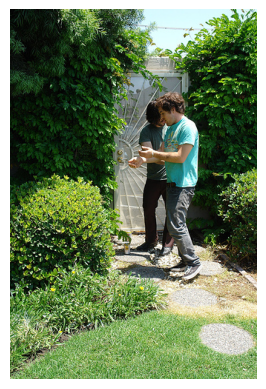

In [5]:
if not USE_CROISSANT:
  # Load annotations and image metadata into a dataframe
  flickr30k_df = pd.read_csv("flickr_annotations_30k.csv", converters={"raw": ast.literal_eval})
  flickr30k_df.rename(columns={"raw": "captions"}, inplace=True)
  display(flickr30k_df.head())
  print(flickr30k_df.info())

  # Verify that the images downloaded correctly
  img_file = flickr30k_df["filename"].values[0]
  img = Image.open(f"flickr30k-images/{img_file}")
  plt.imshow(img)
  plt.axis('off')
  plt.show()

### Download with Croissant

In [ ]:
if USE_CROISSANT:
  # Download Flickr30k metadata from hugging face with croissant
  flickr30k_ds = Dataset(jsonld="https://huggingface.co/api/datasets/nlphuji/flickr30k/croissant")
  records = flickr30k_ds.records("TEST")

  # Print the names of the available record sets
  record_sets = flickr30k_ds.metadata.record_sets
  print(record_sets)

  # Load the images and captions into a dataframe (uses RAM)
  flickr30k_df = pd.DataFrame(flickr30k_ds.records(record_set=record_sets[0].uuid))
  display(flickr30k_df.head())
  flickr30k_df.info()

In [ ]:
if USE_CROISSANT:
  # Rename the columns
  flickr30k_df.rename(columns={
      "TEST/image": "image",
      "TEST/caption": "captions",
      "TEST/sentids": "sentids",
      "TEST/split": "split",
      "TEST/img_id": "img_id",
      "TEST/filename": "filename"
      },
      inplace=True
  )

  # Convert byte strings to strings
  flickr30k_df["split"] = flickr30k_df["split"].apply(lambda x: x.decode("utf-8"))
  flickr30k_df["img_id"] = flickr30k_df["img_id"].apply(lambda x: x.decode("utf-8"))
  flickr30k_df["filename"] = flickr30k_df["filename"].apply(lambda x: x.decode("utf-8"))
  flickr30k_df["captions"] = flickr30k_df["captions"].apply(lambda captions: [caption.decode("utf-8") for caption in captions])
  flickr30k_df["sentids"] = flickr30k_df["sentids"].apply(lambda ids: [id.decode("utf-8") for id in ids])
  display(flickr30k_df.head())

## Exploratory Data Analysis

In [ ]:
# Helper function to search images by caption
def search_image_by_caption(text, show_image=False, exact_match=False):

  # Search all captions by text input (case insensitive)
  if exact_match:
    # Returns any image with a caption that matches the full input
    results = flickr30k_df[flickr30k_df["captions"].apply(lambda x: any(text.lower() in caption.lower() for caption in x))]
  else:
    # Returns any image with a caption that contains the keyword
    results = flickr30k_df[flickr30k_df["captions"].apply(lambda x: any(text.lower() in caption.lower().split() for caption in x))]

  if not results.empty and show_image:
    # Display a random image if there is more than one match
    n = len(results)
    idx = 0 if n <= 1 else random.randint(0, n-1)
    filename = results["filename"].values[idx]

    # If using croissant, retrieve the image from the dataframe
    # else, load the image from disk
    if USE_CROISSANT:
      img = results["image"].values[idx]
    else:
      img = Image.open(f"flickr30k-images/{filename}")

    # Plot image
    plt.imshow(img)
    plt.axis('off')
    print(filename)
    plt.show()

  return results if not results.empty else "No matches."

7033675245.jpg


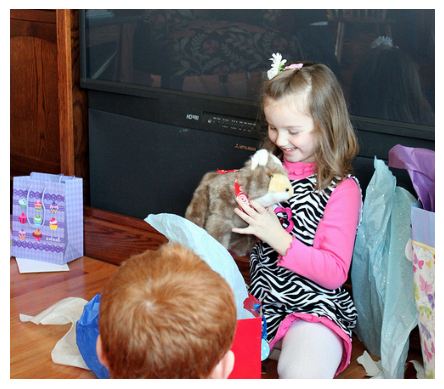

captions  \
1322   [A tall, thin, brunette girl wearing combat bo...   
7853   [There is a person in zebra striped pants and ...   
20566  [Two young women walking, one tall, blond, mod...   
22380  [Some people standing at the corner of a stree...   
22965  [A young girl with blue and pink ribbons in he...   
23572  [An African-American young man is sitting on a...   
26529  [A person dressed up like a panda has surprise...   
28953  [A girl, about 8 years old, is sitting in fron...   
29619  [A girl wearing a black bikini jumps into a la...   

                                        sentids  split        filename  img_id  
1322             [6610, 6611, 6612, 6613, 6614]  train  1400424834.jpg    1322  
7853        [39265, 39266, 39267, 39268, 39269]  train   270684372.jpg    7853  
20566  [102830, 102831, 102832, 102833, 102834]  train  4603100449.jpg   20566  
22380  [111900, 111901, 111902, 111903, 111904]  train  4756001275.jpg   22380  
22965  [114825, 114826, 114827, 114828, 114829]  train  4805835848.jpg   22965  
23572  [117860, 117861, 117862, 117863, 117864]  train  4851225205.jpg   23572  
26529  [132645, 132646, 132647, 132648, 132649]  train  5582687203.jpg   26529  
28953  [144765, 144766, 144767, 144768, 144769]  train  7033675245.jpg   28953  
29619  [148095, 148096, 148097, 148098, 148099]  train   755396653.jpg   29619

In [ ]:
# Test image search helper function (keyword search)
search_image_by_caption("zebra", show_image=True)

5450688421.jpg


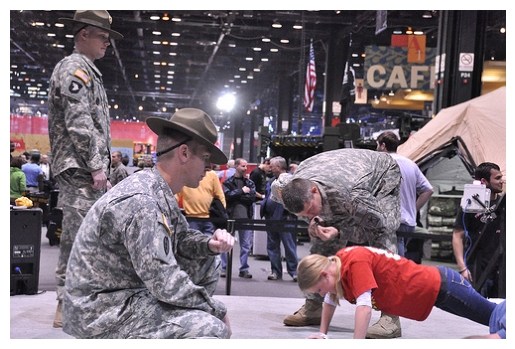

captions  \
26308  [Two soldiers at an event center are watching ...   

                                        sentids  split        filename  img_id  
26308  [131540, 131541, 131542, 131543, 131544]  train  5450688421.jpg   26308

In [ ]:
# Test image search helper function (exact match)
search_image_by_caption("Think you can do as many as the lieutenant?", show_image=True, exact_match=True)

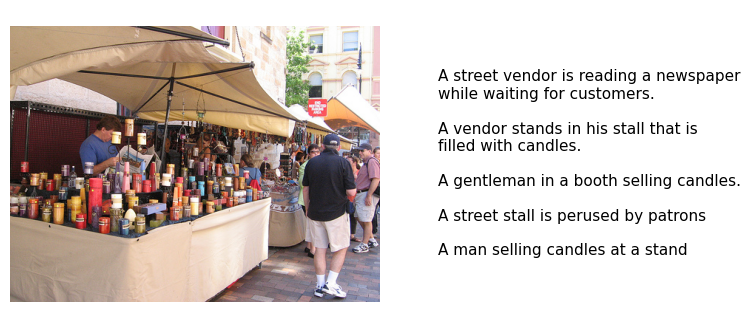

In [ ]:
# Pick a random image
rs = flickr30k_df.sample(n=1)

# Plot the image and its captions
fig, ax = plt.subplots(1, 2, figsize=(6, 4), gridspec_kw={'width_ratios': [5, 1]})

# Load the image
if USE_CROISSANT:
  img = rs["image"].values[0]
else:
  img_name = rs["filename"].values[0]
  img = Image.open(f"flickr30k-images/{img_name}")

# Plot the image
ax[0].imshow(img)
ax[0].set_axis_off()

# Plot the captions
captions = rs["captions"].iloc[0]
ax[1].text(0.5, 0.5, "\n\n".join([textwrap.fill(caption, width=40) for caption in captions]), va='center', fontsize=11)
ax[1].set_axis_off()

plt.subplots_adjust(wspace=0.1)
plt.show()

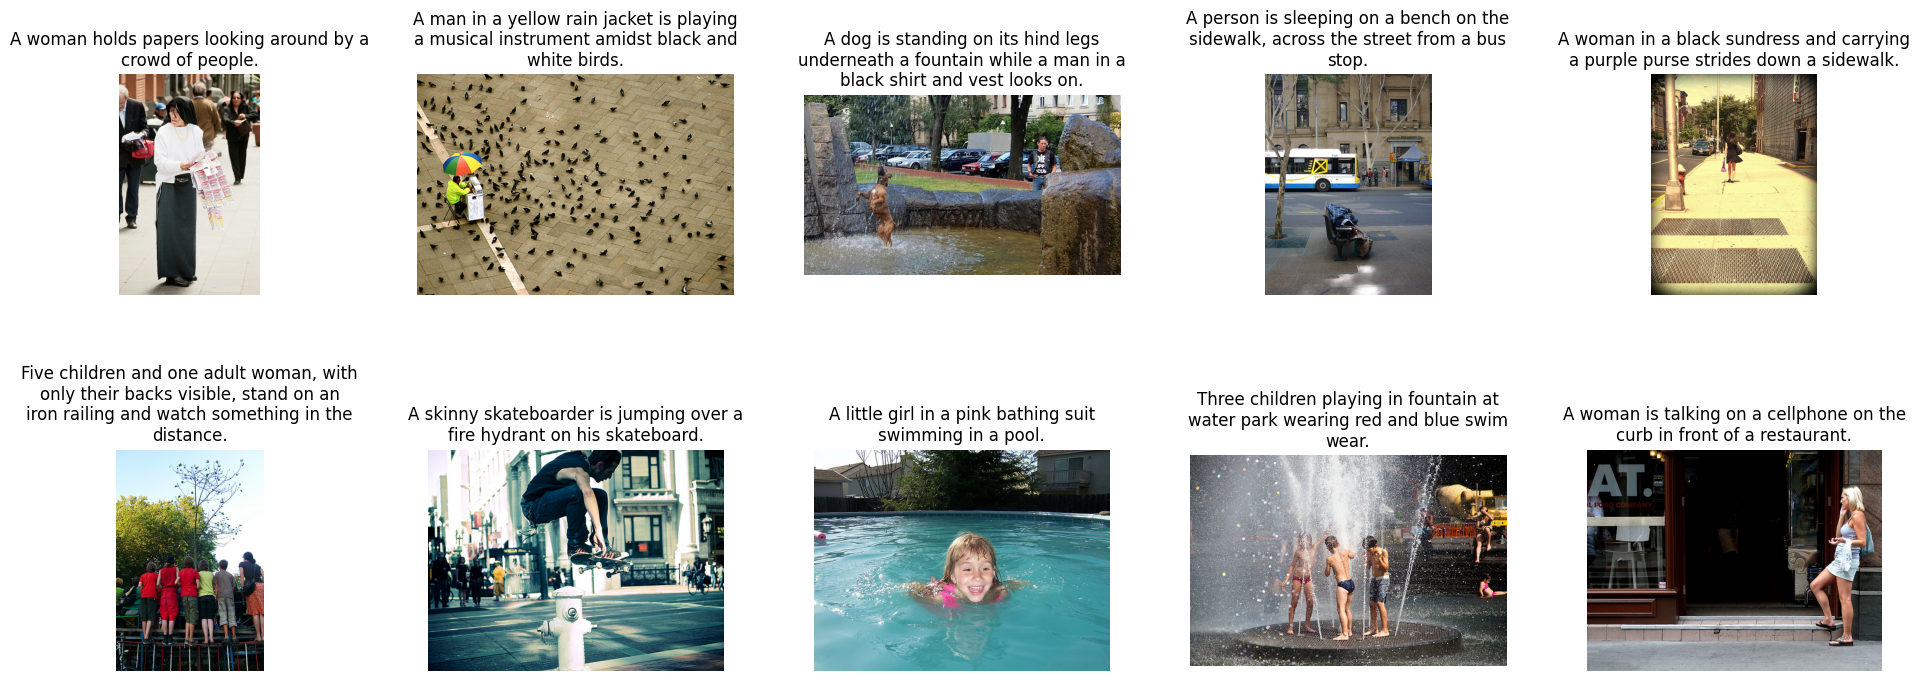

In [ ]:
# Print a random sample of 10 images and their captions
rs = flickr30k_df.sample(n=10)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

axs = axs.flatten()

# Plot each image and its first caption
for i, ax in enumerate(axs):
  if USE_CROISSANT:
    img = rs["image"].values[i]
  else:
    img_name = rs["filename"].values[i]
    img = Image.open(f"flickr30k-images/{img_name}")
  ax.imshow(img)
  caption = rs["captions"].iloc[i][0]
  ax.set_title(textwrap.fill(caption, width=40))
  ax.set_axis_off()

fig.tight_layout(pad=5.0)
plt.show()

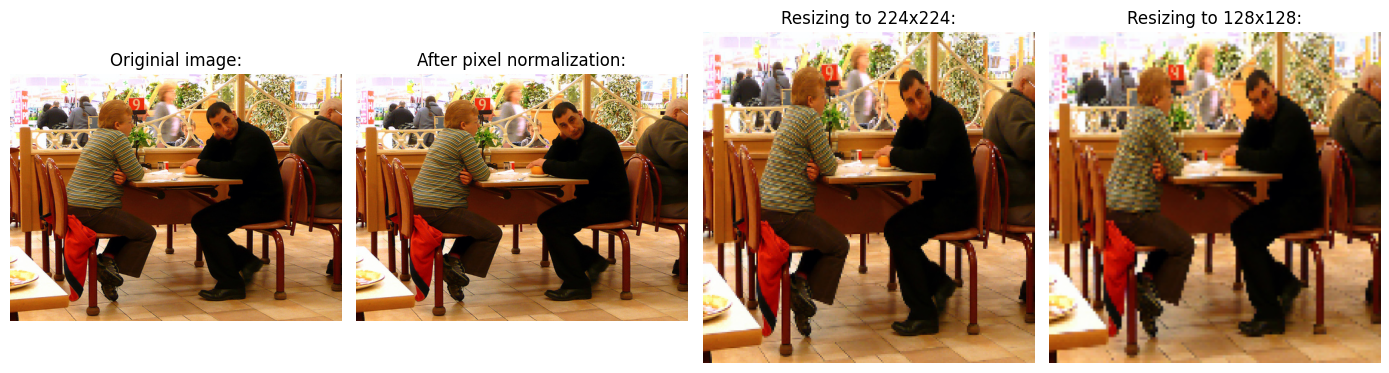

In [ ]:
# Test image preprocessing methods
rs = flickr30k_df.sample(n=1)

# Load the image
if USE_CROISSANT:
  img = rs["image"].values[0]
else:
  img_name = rs["filename"].values[0]
  img = Image.open(f"flickr30k-images/{img_name}")

# Normalize the pixel values
img_tensor = tf.convert_to_tensor(img)
img_norm = img_tensor/255

# Resize the image to 224x224
img_224 = tf.image.resize(img_norm, [224, 224])

# Resize the image to 128x128
img_128 = tf.image.resize(img_norm, [128, 128])

# Plot the original image and each of its transformations
fig, ax = plt.subplots(1, 4, figsize=(14, 7))
ax[0].set_title("Originial image:")
ax[0].imshow(img)
ax[0].axis('off')
ax[1].set_title("After pixel normalization:")
ax[1].imshow(img_norm)
ax[1].axis('off')
ax[2].set_title("Resizing to 224x224:")
ax[2].imshow(img_224)
ax[2].axis('off')
ax[3].set_title("Resizing to 128x128:")
ax[3].imshow(img_128)
ax[3].axis('off')

fig.tight_layout()
plt.show()

In [6]:
# Get all of the captions for EDA
all_captions = [caption for captions in flickr30k_df["captions"] for caption in captions]
all_captions[:5]

['Two young guys with shaggy hair look at their hands while hanging out in the yard.',
 'Two young, White males are outside near many bushes.',
 'Two men in green shirts are standing in a yard.',
 'A man in a blue shirt standing in a garden.',
 'Two friends enjoy time spent together.']

Total number of captions: 155070
Mean caption length: 63.2
Median caption length: 58.0
Caption length standard dev: 26.68
Min length: 7
Q1: 45.0
Q3: 75.0
95th percentile: 113.0
Max length: 402


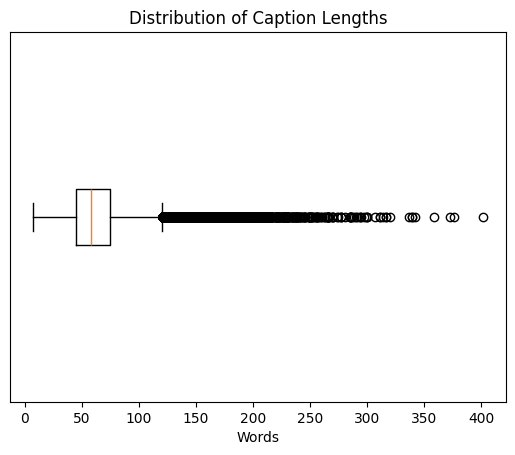

In [7]:
# Compute descriptive statistics for the captions
print(f"Total number of captions: {len(all_captions)}")

caption_lengths = [len(caption) for caption in all_captions]

print(f"Mean caption length: {np.round(np.mean(caption_lengths), 2)}")
print(f"Median caption length: {np.median(caption_lengths)}")
print(f"Caption length standard dev: {np.round(np.std(caption_lengths), 2)}")
print(f"Min length: {np.min(caption_lengths)}")
print(f"Q1: {np.quantile(caption_lengths, 0.25)}")
print(f"Q3: {np.quantile(caption_lengths, 0.75)}")
print(f"95th percentile: {np.quantile(caption_lengths, 0.95)}")
print(f"Max length: {np.max(caption_lengths)}")

# Plot the distribution
plt.title("Distribution of Caption Lengths")
plt.xlabel("Words")
plt.boxplot(caption_lengths, vert=0)
plt.yticks([])
plt.show()

In [8]:
# Find non-alphabetic characters in the captions
unique_chars = {char for caption in all_captions for char in caption if not char.isalpha()}
print(unique_chars)

{'0', '?', '1', '@', '+', '=', ';', '&', '#', ',', '7', ')', '6', ':', ' ', '9', '"', '3', '8', '`', '2', '%', '(', '.', '4', '-', '$', "'", '5', '!'}


In [9]:
# Inspect instances of captions that use non-alphabetic characters (pound sign)
special_char_captions = [caption for caption in all_captions if "#" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 41


['A UH football player, #15, stands near the edge of the field ready to throw the ball while his teammate blocks an opponent.',
 'A little-league baseball player, wearing a white #19 jersey, successfully hits the ball.',
 'A football player is in a red and white uniform Sooners #28.',
 'A black greyhound, with a green and white jersey (#7) is running on a track.',
 'The #2 greyhound dog is running around a track.']

In [10]:
# Inspect instances of captions that use non-alphabetic characters (at sign)
special_char_captions = [caption for caption in all_captions if "@" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 3


['@ men are kneeling with their hands in front of them.',
 '@ people are cleaning windows in a dark environment.',
 '@ males wearing a black shirt and a brown shirt are looking at vegetation.']

In [11]:
# Inspect instances of captions that use non-alphabetic characters (percent sign)
special_char_captions = [caption for caption in all_captions if "%" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 12


['Man outside in the rain promoting a 50 % off sale.',
 'An elderly man held the "COLLEGE KRUGT DINERS EN 3 %" sign as he stood near the brick building.',
 'A group of women are all sitting in a department store looking at some papers or booklets, and a large sign indicates 40 % off sale.',
 '2 men getting ready to cross the street under the 25 % off sign.',
 '2 rows of woman walking towards each other on the sidewalk outside of a store with a boy 50 % sign on the golden framed windows.']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (colon)
special_char_captions = [caption for caption in all_captions if ":" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[10:15]

Total instances: 31


['Left to right : a girl in an orange coat, a young boy with a camera and red coat, and a woman with a scarf.',
 "Celebrating St. Patrick's Day at 2:10 pm &amp; an police officer is going inside a room.",
 'A group of men finish a fund raising run for Haiti in 28:24.',
 'A large gold trimmed clock indicates that the time is 1:10.',
 'A woman in a blue coat walks in front of a sign with green men walking under the two words :berlin and kathmandu']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (equal sign)
special_char_captions = [caption for caption in all_captions if "=" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 2


['Two young children RIF=ding sleds down the snow.',
 'People passing through an open market, while an older woman leans in front of a chilled bin on=f seafood.']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (plus sign)
special_char_captions = [caption for caption in all_captions if "+" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 3


['A Chinese + man and younger boy in some type of worship place worshiping.',
 'An elderly woman wearing a green parka +is walking with a cane near an intersection.',
 '8+ people sitting on wood benches are viewing 8 people in brown.']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (ampersand)
special_char_captions = [caption for caption in all_captions if "&" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 90


['Grocery store employee, dressed in a red apron &amp; a baseball cap, sits on a ledge in front of the store.',
 'Two ladies are cooking &amp; talking and two gentlemen are talking in the opposite site of the kitchen.',
 'A woman in a black shirt sitting behind a booth with a sign that reads "Programmes &amp; Ice Cream."',
 'Eight gentlemen are working with stone &amp; tile.',
 'A dozen workers wearing uniforms &amp; sanitation hats are working on an assembly line in a factory.']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (question mark)
special_char_captions = [caption for caption in all_captions if "?" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions

Total instances: 38


['A crowd admiring modern art?',
 'The green team lifts a player up in victory after a hard game, but will the red team interfere?',
 'It takes a real man to clean a bucket with who knows what in it?',
 "That hotdog just wasn't going down right, was it the drinking or the burnt dog?",
 'People walking through a short tunnel with "Where are you?" written on the wall.',
 'A man walks under a bridge and reads grafitti that reads "WHERE ARE YOU"?',
 'A man with a cigerette walks past graffitti which says "Where are you?"',
 'A man is walking next to a wall with "Where are you?" painted on it.',
 'A man walking reads a wall asking "Where are you?".',
 'How do we get to the other side?',
 'A person riding transit (catching?) a paper bag.',
 'Two people pose for a picure holding a card that says "know what this is?"',
 'Two girls hold up a card reading "know what this is"?',
 'Man with cupcakes and coffee contemplating the statement "who are you?"',
 'A man in glasses writes the message "Who 

460921330.jpg


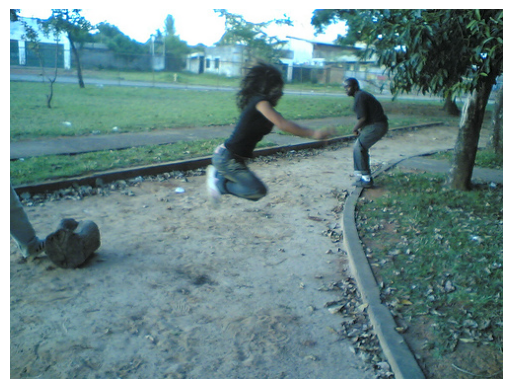

['A girl in a black shirt is jumping in a sandy area, and a man in a black shirt is bending over in the background.',
 "Did someone yell snake? Because it seems she's out of here!",
 'A woman jumping as a man idly watches her in midair.',
 'She is jumping high in the air.',
 'People outdoors at a park.']

In [ ]:
results = search_image_by_caption("Did someone yell snake? Because it seems she's out of here!", show_image=True, exact_match=True)
results["captions"].iloc[0]

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (exclamation mark)
special_char_captions = [caption for caption in all_captions if "!" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 96


['Looks like everyone is getting good gas mileage here with all these beautiful scooters!',
 'Man on an ATV catching air!',
 'Roller derby girls waiting for the next round of action!',
 'A sweet young lady deciding whats for breakfast!',
 'A yellow taxi cab with a sign reading "MAMA MIA!" on it, and a guy sitting in the back.']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (numbers)
special_char_captions = [caption for caption in all_captions if any(char in caption for char in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 1776


['2 kids playing on a seesaw',
 'Small group of 5 white males in white suits hanging out by the back of a van in a parking lot talking.',
 '2 female babies eating chips.',
 'Man walking up to silver 4-wheeled chair',
 'A man in an orange shirt sings for the crowd below a sign that says Lucky 13.']

## Caption Preprocessing

### Text Cleaning

In [12]:
# Save all the captions before cleaning to compare difference in vocabulary size
all_captions_raw = [caption for captions in flickr30k_df["captions"] for caption in captions]

In [13]:
def preprocess_captions(captions):
  cleaned_captions = []
  for caption in captions:
    # Convert caption to lowercase
    caption = caption.lower()

    # Remove punctuation
    caption = re.sub(r"[.,;!?`]", "", caption)

    # Replace pound sign with the word number
    caption = caption.replace("#", "number")

    # Replace percent sign with the word percent
    caption = caption.replace("%", "percent")

    # Replace ampersand with the word and
    caption = caption.replace("&amp", "and")

    # Remove other characters that are not useful
    caption = re.sub(r"[@+=()]", "", caption)

    # Remove excess whitespace
    caption = re.sub(r"\s+", " ", caption).strip()

    cleaned_captions.append(caption)

  return cleaned_captions

In [14]:
# Test the text preprocessing method on a single text
test_caption = ["Test.  caption (12), &amp; 34 @; + # % !", "(anoth=r) test caption"]
print(f"Original captions: {test_caption}")
print(f"After cleaning: {preprocess_captions(test_caption)}")

Original captions: ['Test.  caption (12), &amp; 34 @; + # % !', '(anoth=r) test caption']
After cleaning: ['test caption 12 and 34 number percent', 'anothr test caption']


In [15]:
# Apply preprocessing method to all the captions
flickr30k_df["captions"] = flickr30k_df["captions"].apply(preprocess_captions)
flickr30k_df["captions"].head()

0    [two young guys with shaggy hair look at their...
1    [several men in hard hats are operating a gian...
2    [a child in a pink dress is climbing up a set ...
3    [someone in a blue shirt and hat is standing o...
4    [two men one in a gray shirt one in a black sh...
Name: captions, dtype: object

## Split Data

In [16]:
# Split data into train test and val sets
train_df = flickr30k_df[flickr30k_df["split"] == 'train']
print(train_df.info())

test_df = flickr30k_df[flickr30k_df["split"] == 'test']
print(test_df.info())

val_df = flickr30k_df[flickr30k_df["split"] == 'val']
print(val_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29000 entries, 0 to 31013
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   captions  29000 non-null  object
 1   sentids   29000 non-null  object
 2   split     29000 non-null  object
 3   filename  29000 non-null  object
 4   img_id    29000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 25 to 30943
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   captions  1000 non-null   object
 1   sentids   1000 non-null   object
 2   split     1000 non-null   object
 3   filename  1000 non-null   object
 4   img_id    1000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1014 entries, 67 to 30999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  -----

## Caption Encoder and Data Generator base clases

In [17]:
# Caption encoder base class
# Must specify a method of encoding a caption and decoding a caption
class CaptionEncoder:
  def __init__(self, vocab, seq_length):
    # Set the vocabulary, vocabulary size, and length of the sequences
    self.vocab = vocab
    self.vocab_size = len(vocab)
    self.seq_length = seq_length

  # Encoding method
  def encode(self, caption):
    pass

  # Decoding method
  def decode(self, encoding):
    pass

In [18]:
# Data generator base class
# Must specify __getitem__ and __len__
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self):
    pass

  # Customizes the object accessor [] to retrieve the batch at a particular index
  def __getitem__(self, idx):
    pass

  # Customizes built in len() method to return the number of batches per epoch
  def __len__(self):
    pass

  # Specify what to do at the end of a training epoch (optional)
  def on_epoch_end(self):
    pass

## Models

### CNN + TBD

#### Caption Tokenization and Encoding

In [ ]:
# Define a method to create a token vocabulary from the caption text corpus
def create_vocabulary(captions):

  # Create a set to store unique tokens
  unique_tokens = set()

  # Add the start and end sequence tokens to the vocabulary
  special_tokens = ["<START>", "<END>"]
  unique_tokens.update(special_tokens)

  # Tokenize each caption and add its tokens to the vocabulary
  for caption in captions:
    caption_tokens = word_tokenize(caption)
    unique_tokens.update(caption_tokens)
  return unique_tokens

# Get all of the captions
all_captions_cleaned = [caption for captions in flickr30k_df["captions"] for caption in captions]

# Test on the first caption
single_caption_vocab = create_vocabulary(all_captions_cleaned[:1])
print(all_captions_cleaned[:1])
print(single_caption_vocab)

['two young guys with shaggy hair look at their hands while hanging out in the yard']
{'look', 'young', 'in', 'their', 'the', '<END>', 'hanging', 'shaggy', 'while', 'yard', 'hands', 'hair', 'guys', 'two', 'out', 'with', 'at', '<START>'}


In [ ]:
# Create the full vocabulary (raw captions)
full_vocab = create_vocabulary(all_captions_raw)

# Print vocab size (raw captions size)
print(f"Vocab size (without text cleaning): {len(full_vocab)}")

Vocab size (without text cleaning): 23314


In [ ]:
# Create the full vocabulary (cleaned captions)
full_vocab = create_vocabulary(all_captions_cleaned)

# Print vocab size (cleaned captions)
print(f"Vocab size (after text cleaning): {len(full_vocab)}")

Vocab size (after text cleaning): 20153


In [ ]:
# Define a class that creates a custom caption encoder object that handles tokenizing and
# encoding/decoding a set of captions
class CustomCaptionEncoder(CaptionEncoder):
  def __init__(self, vocab, seq_length):
    # Set the vocabulary, vocabulary size, and length of the sequences
    self.vocab = vocab
    self.vocab_size = len(vocab)
    self.seq_length = seq_length

    # Define mappings for token to id and id to token
    # ID 0 is reserved for padding
    self.token_to_id = {token: id+1 for id, token in enumerate(vocab)}
    self.id_to_token = {id: token for token, id in self.token_to_id.items()}

  def encode(self, caption):
    # Add the start sequence token to the beginning on the caption tokens
    caption_tokens = ["<START>"] + word_tokenize(caption)

    # Convert each token to its id
    encoding = [self.token_to_id[token] for token in caption_tokens]

    # If the sequence is too short, pad it to the sequence length
    if len(encoding) < self.seq_length-1:
      padding = [0] * (self.seq_length - 1 - len(encoding))
      encoding.extend(padding)
    # If the sequence is too long, truncate it to the sequence length
    else:
      encoding = encoding[:self.seq_length-1]

    # Add the end sequence token
    end_token = self.token_to_id["<END>"]
    encoding.extend([end_token])

    return encoding

  def decode(self, encoding):
    # Convert the encoding back into tokens
    return [self.id_to_token[id] for id in encoding if id != 0]


In [ ]:
# Test the custom caption encoder on the vocabulary from a single caption
encoder = CustomCaptionEncoder(single_caption_vocab, 25)
print(f"Token to ID mapping: {encoder.token_to_id}")
print(f"ID to Token mapping: {encoder.id_to_token}\n")

# Encode the first caption
encoded_caption = encoder.encode(all_captions_cleaned[0])
print(f"Encoded caption: {encoded_caption}")

# Decode the encoded caption
print(f"Decoded caption: {encoder.decode(encoded_caption)}")

Token to ID mapping: {'hair': 1, 'while': 2, 'their': 3, 'look': 4, 'yard': 5, '<START>': 6, 'hanging': 7, 'guys': 8, 'at': 9, '<END>': 10, 'young': 11, 'two': 12, 'in': 13, 'the': 14, 'hands': 15, 'out': 16, 'shaggy': 17, 'with': 18}
ID to Token mapping: {1: 'hair', 2: 'while', 3: 'their', 4: 'look', 5: 'yard', 6: '<START>', 7: 'hanging', 8: 'guys', 9: 'at', 10: '<END>', 11: 'young', 12: 'two', 13: 'in', 14: 'the', 15: 'hands', 16: 'out', 17: 'shaggy', 18: 'with'}

Encoded caption: [6, 12, 11, 8, 18, 17, 1, 4, 9, 3, 15, 2, 7, 16, 13, 14, 5, 0, 0, 0, 0, 0, 0, 0, 10]
Decoded caption: ['<START>', 'two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hands', 'while', 'hanging', 'out', 'in', 'the', 'yard', '<END>']


In [ ]:
# Create a custom caption encoder on the full vocabulary to use in the models
custom_caption_encoder = CustomCaptionEncoder(full_vocab, 120)

#### Data Generator

In [ ]:
# Define a class that builds a data generator object for dynamically loading data
class CustomDataGenerator(DataGenerator):
  def __init__(self, df, caption_encoder, im_width, im_height, batch_size=32, shuffle=True):
    self.data = df
    self.caption_encoder = caption_encoder
    self.im_width = im_width
    self.im_height = im_height
    self.batch_size = batch_size
    self.shuffle = shuffle

  # Customizes the object accessor [] to retrieve the batch at a particular index
  def __getitem__(self, idx):

    # Get the range of indices for this batch
    low = idx * self.batch_size
    high = min(low + self.batch_size, len(self.data))

    # Retrieve the batch
    batch = self.data[low:high]

    images = batch["image"]
    batch_captions = batch["captions"]
    caption_sequences = []
    y = []
    image_tensors = []

      # For each image, normalize its pixel values and resize it
    for img in images:
      img_tensor = tf.convert_to_tensor(img)
      img_tensor = tf.image.resize(img_tensor, [self.im_width, self.im_height])
      img_tensor = img_tensor/255.0
      image_tensors.append(img_tensor)

    for captions in batch_captions:
      caption_idx = random.randint(0, 4)
      caption = captions[caption_idx]
      encoding = self.caption_encoder.encode(caption)

      for i in range(1, len(encoding)):
          # Create input and output sequences from the captions, e.g.
          # <START> -> a
          # <START> a -> sample
          # <START> a sample -> caption
        caption_input, output = encoding[:i], encoding[i]
        padding = [0] * (self.caption_encoder.seq_length - 1 - len(caption_input))
        caption_input.extend(padding)
        output = to_categorical([output], num_classes=self.caption_encoder.vocab_size)
        caption_sequences.append(caption_input)
        y.append(output)
        # image_tensors.append(img_tensor)

        #image_captions.append(encoding)
    y = np.array(y).reshape(-1, self.caption_encoder.vocab_size)

    # # Load the images from the dataframe
    # if USE_CROISSANT:
    #   images = batch["image"]
    #   image_tensors = []

    #   # For each image, normalize its pixel values and resize it
    #   for img in images:
    #     img_tensor = tf.convert_to_tensor(img)
    #     img_tensor = tf.image.resize(img_tensor, [self.im_width, self.im_height])
    #     img_tensor = img_tensor/255.0
    #     image_tensors.append(img_tensor)

    # # If the images are on disk, use multithreading to load and transform the images in parallel
    # else:
    #   image_files = batch["filename"]
    #   with ThreadPoolExecutor() as executor:
    #     image_tensors = list(executor.map(self.load_image_from_file, image_files))

    # # For each image, choose one of its captions at random and tokenize and encode it
    # image_captions = []
    # batch_captions = batch["captions"]

    # caption_sequences = []
    # y = []
    # for captions in batch_captions:
    #   caption_idx = random.randint(0, 4)
    #   caption = captions[caption_idx]
    #   encoding = self.caption_encoder.encode(caption)

    #   for i in range(1, len(encoding)):
    #     # Create input and output sequences from the captions, e.g.
    #     # <START> -> a
    #     # <START> a -> sample
    #     # <START> a sample -> caption
    #     caption_input, output = encoding[:i], encoding[i]
    #     padding = [0] * (self.caption_encoder.seq_length - 1 - len(caption_input))
    #     caption_input.extend(padding)
    #     #caption_input, output = caption[:i], caption[i]
    #     output = to_categorical([output], num_classes=self.caption_encoder.vocab_size)
    #     # print("in", caption_input)
    #     # print("out", output.shape)
    #     caption_sequences.append(caption_input)
    #     y.append(output)

    #   #image_captions.append(encoding)
    # y = np.array(y).reshape(-1, self.caption_encoder.vocab_size)

    # Return a batch of images and captions
    return (np.array(image_tensors), np.array(caption_sequences)), y

    # # Return a batch of images and captions
    # return np.array(image_tensors) #, np.array(image_captions)

  # Customize built in len() method to return the number of batches per epoch
  def __len__(self):
    return int(np.ceil(len(self.data) / float(self.batch_size)))

  # If shuffle is enabled, shuffle the data at the end of each epoch
  def on_epoch_end(self):
    if self.shuffle:
      self.data = self.data.sample(frac=1).reset_index(drop=True)

  # Helper function to load and preprocess an image from disk
  def load_image_from_file(self, filename):
    img = Image.open(f"flickr30k-images/{filename}")
    img_tensor = tf.convert_to_tensor(img)
    img_tensor = tf.image.resize(img_tensor, [128, 128])
    img_tensor = img_tensor/255.0
    return img_tensor

In [ ]:
generator = DataGenerator(train_df, custom_caption_encoder, 128, 128, batch_size=32)

In [ ]:
len(generator)

907

In [ ]:
inputs, outputs = generator[0]

In [ ]:
inputs[0].shape

(32, 128, 128, 3)

In [ ]:
inputs[1].shape

(3808, 119)

In [ ]:
outputs.shape

(3808, 20153)

In [ ]:
outputs.reshape(-1, outputs.shape[-1]).shape

(401, 20153)

In [ ]:
generator = DataGenerator(train_df, custom_caption_encoder, 128, 128, batch_size=64)
print(f"Batches per epoch: {len(generator)}")

# Take the first batch
img_batch, input_sequences_batch, output_sequences_batch = generator[0]

Batches per epoch: 454


In [ ]:
img_batch.shape, input_sequences.shape, output_sequences.shape

((64, 128, 128, 3), (401, 401), (401, 1, 20153))

In [ ]:
batch[1].shape

(401, 401)

In [ ]:
batch[2].shape

(401, 1, 20153)

In [ ]:
# Instantiate a data generator for testing
generator = DataGenerator(train_df, custom_caption_encoder, 128, 128, batch_size=64)
print(f"Batches per epoch: {len(generator)}")

# Take the first batch
img_batch, input_sequences_batch, output_sequences_batch = generator[0]
print(f"Images shape: {img_batch.shape}")
print(f"Caption input shape: {input_sequences_batch.shape}")
print(f"Ground truth shape: {output_sequences_batch.shape}")

# # Print an image from the batch and its caption
# print(" ".join(custom_caption_encoder.decode(caption_batch[0])))
# plt.imshow(img_batch[0])
# plt.show()

Batches per epoch: 454
Images shape: (64, 128, 128, 3)
Caption input shape: (401, 401)
Ground truth shape: (401, 1, 20153)


In [ ]:
# Simulate a run of 10 epochs to test that the data generator will run through
# all of the images without crashing
num_epochs = 10

# Start experiment timer
test_start_time = time.time()

# For each epoch, retrieve every batch for that epoch
for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}/{num_epochs}")
  print("Generating batches...")

  # Start epoch timer
  epoch_start_time = time.time()

  # Load each batch in the epoch
  for batch_idx in range(len(generator)):
    batch = generator[batch_idx]

  # Shuffle the data
  generator.on_epoch_end()

  # End epoch timer
  epoch_end_time = time.time()
  print(f"Completed in {np.round((epoch_end_time - epoch_start_time), 3)} s")

# End experiment timer
test_end_time = time.time()
print(f"Test completed in {np.round((test_end_time - test_start_time), 3)} s.")

In [ ]:
mini_df = train_df.sample(n=1000)
mini_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 23272 to 12299
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     1000 non-null   object
 1   captions  1000 non-null   object
 2   sentids   1000 non-null   object
 3   split     1000 non-null   object
 4   img_id    1000 non-null   object
 5   filename  1000 non-null   object
dtypes: object(6)
memory usage: 54.7+ KB


In [ ]:
mini_generator = DataGenerator(mini_df, custom_caption_encoder, 128, 128, batch_size=8)

In [ ]:
image_input_shape = mini_generator[0][0][0].shape[1:]
caption_input_shape = mini_generator[0][0][1].shape[1:]
vocab_size = len(full_vocab)

In [ ]:
mini_generator[0][0][0].shape

(1592, 128, 128, 3)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Embedding, Concatenate, Add, add, Reshape, LSTM, RepeatVector, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [ ]:
# Instantiate generators for each data split
im_width = 128
im_height = 128
batch_size = 32

train_generator = DataGenerator(train_df, custom_caption_encoder, im_width, im_height, batch_size=batch_size)
test_generator = DataGenerator(test_df, custom_caption_encoder, im_width, im_height, batch_size=batch_size)
val_generator = DataGenerator(val_df, custom_caption_encoder, im_width, im_height, batch_size=batch_size)

In [ ]:
train_generator[0][0][0].shape

(32, 128, 128, 3)

In [ ]:
image_input_shape = train_generator[0][0][0].shape[1:]
caption_input_shape = train_generator[0][0][1].shape[1:]
vocab_size = len(full_vocab)

In [ ]:
train_generator[0][0][1].shape[0]

3808

In [ ]:
image_input_shape, caption_input_shape

((128, 128, 3), (119,))

In [ ]:
train_generator.caption_encoder.seq_length

120

In [ ]:
train_generator.caption_encoder.seq_length-1

119

In [ ]:
train_generator[0][0][0].shape

(32, 128, 128, 3)

In [ ]:
tf.tile(train_generator[0][0][0], [119, 1, 1, 1]).shape

TensorShape([3808, 128, 128, 3])

In [ ]:
from einops import repeat

# Repeat each image in the batch 4 times along a new dimension
repeated = repeat(train_generator[0][0][0], 'b c h w -> (repeat b) c h w', repeat=119)

In [ ]:
repeated.shape

(3808, 128, 128, 3)

In [ ]:
!pip install --upgrade einops

In [ ]:
image_input = Input(shape=image_input_shape)

c1 = Conv2D(32, 3, activation="relu")(image_input)
c2 = Conv2D(32, 3, activation="relu")(c1)
p1 = GlobalAveragePooling2D()(c2)
d1 = Dense(units=12)(p1)
print(d1.shape)
expand = Reshape((1, 12))(d1)
print(expand.shape)
repeated = Lambda(lambda x: tf.tile(x, [119, 1, 1]))(expand)
print(repeated.shape)
#repeat = RepeatVector(train_generator.caption_encoder.seq_length-1)(d1)
#im = Reshape((1, 12))(d1)
#repeated = repeat(d1, 'b c h w -> (repeat b) c h w', repeat=119)

caption_input = Input(shape=caption_input_shape)

e = Embedding(vocab_size, 12, mask_zero=True)(caption_input)
#mask = e._keras_mask
#print(mask)
concat = Concatenate(axis=1)([repeated, e])
masked_concat = Masking()(concat)

lstm = LSTM(128)(masked_concat)
d2 = Dense(256, activation="relu")(lstm)
output = Dense(units=vocab_size, activation="softmax")(d2)

model = Model([image_input, caption_input], output)

AttributeError: 'KerasTensor' object has no attribute 'numpy'

In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
class DuplicateImageFeatures(Layer):
  def __init__(self, seq_length):
    super(DuplicateImageFeatures, self).__init__()
    self.seq_length = seq_length

  def call(self, input):
    expand = tf.expand_dims(input, axis=1)
    tile = tf.tile(expand, [1, self.seq_length, 1])
    return tile

In [ ]:
image_input = Input(shape=image_input_shape)

c1 = Conv2D(32, 3, activation="relu")(image_input)
c2 = Conv2D(16, 3, activation="relu")(c1)
p1 = GlobalAveragePooling2D()(c2)
image_features = Dense(units=128)(p1)

tile = DuplicateImageFeatures(119)(image_features)

#expand = Reshape((1, 128))(image_features)
#tile = Lambda(lambda x: tf.tile(x, [1, 119, 1]))(expand)

#repeat = RepeatVector(train_generator.caption_encoder.seq_length-1)(image_features)

caption_input = Input(shape=caption_input_shape)
e = Embedding(vocab_size, 128, mask_zero=False)(caption_input)
lstm1 = LSTM(128, return_sequences=True)(e)


add = Add()([tile, lstm1])
#concat = Concatenate(axis=-1)([repeat, lstm1])
lstm2 = LSTM(128)(concat)
d2 = Dense(256, activation="relu")(lstm2)


output = Dense(units=vocab_size, activation="softmax")(d2)

model2 = Model([image_input, caption_input], output)

In [ ]:
tile.shape

(None, 119, 128)

In [ ]:
tile.shape

(None, 119, 128)

In [ ]:
expand.shape

(None, 1, 128)

In [ ]:
image_features.shape

(None, 128)

In [ ]:
add.shape

(None, 119, 128)

In [ ]:
repeat.shape

(None, 119, 128)

In [ ]:
lstm1.shape

(None, 119, 128)

In [ ]:
model2.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 126, 126, 32)   │            896 │ input_layer_36[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 124, 124, 16)   │          4,624 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 16)             │              0 │ conv2d_41[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_48 (Dense)          │ (None, 12)             │            204 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_37            │ (None, 119)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_8           │ (None, 119, 12)        │              0 │ dense_48[0][0]         │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_16 (Embedding)  │ (None, 119, 12)        │        241,836 │ input_layer_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 238, 12)        │              0 │ repeat_vector_8[0][0], │
│ (Concatenate)             │                        │                │ embedding_16[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_39 (LSTM)            │ (None, 128)            │         72,192 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_64 (Dense)          │ (None, 256)            │         33,024 │ lstm_39[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_47            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_48            │ (None, 119)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_65 (Dense)          │ (None, 20153)          │      5,179,321 │ dense_64[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,532,097 (21.10 MB)

 Trainable params: 5,532,097 (21.10 MB)

 Non-trainable params: 0 (0.00 B)

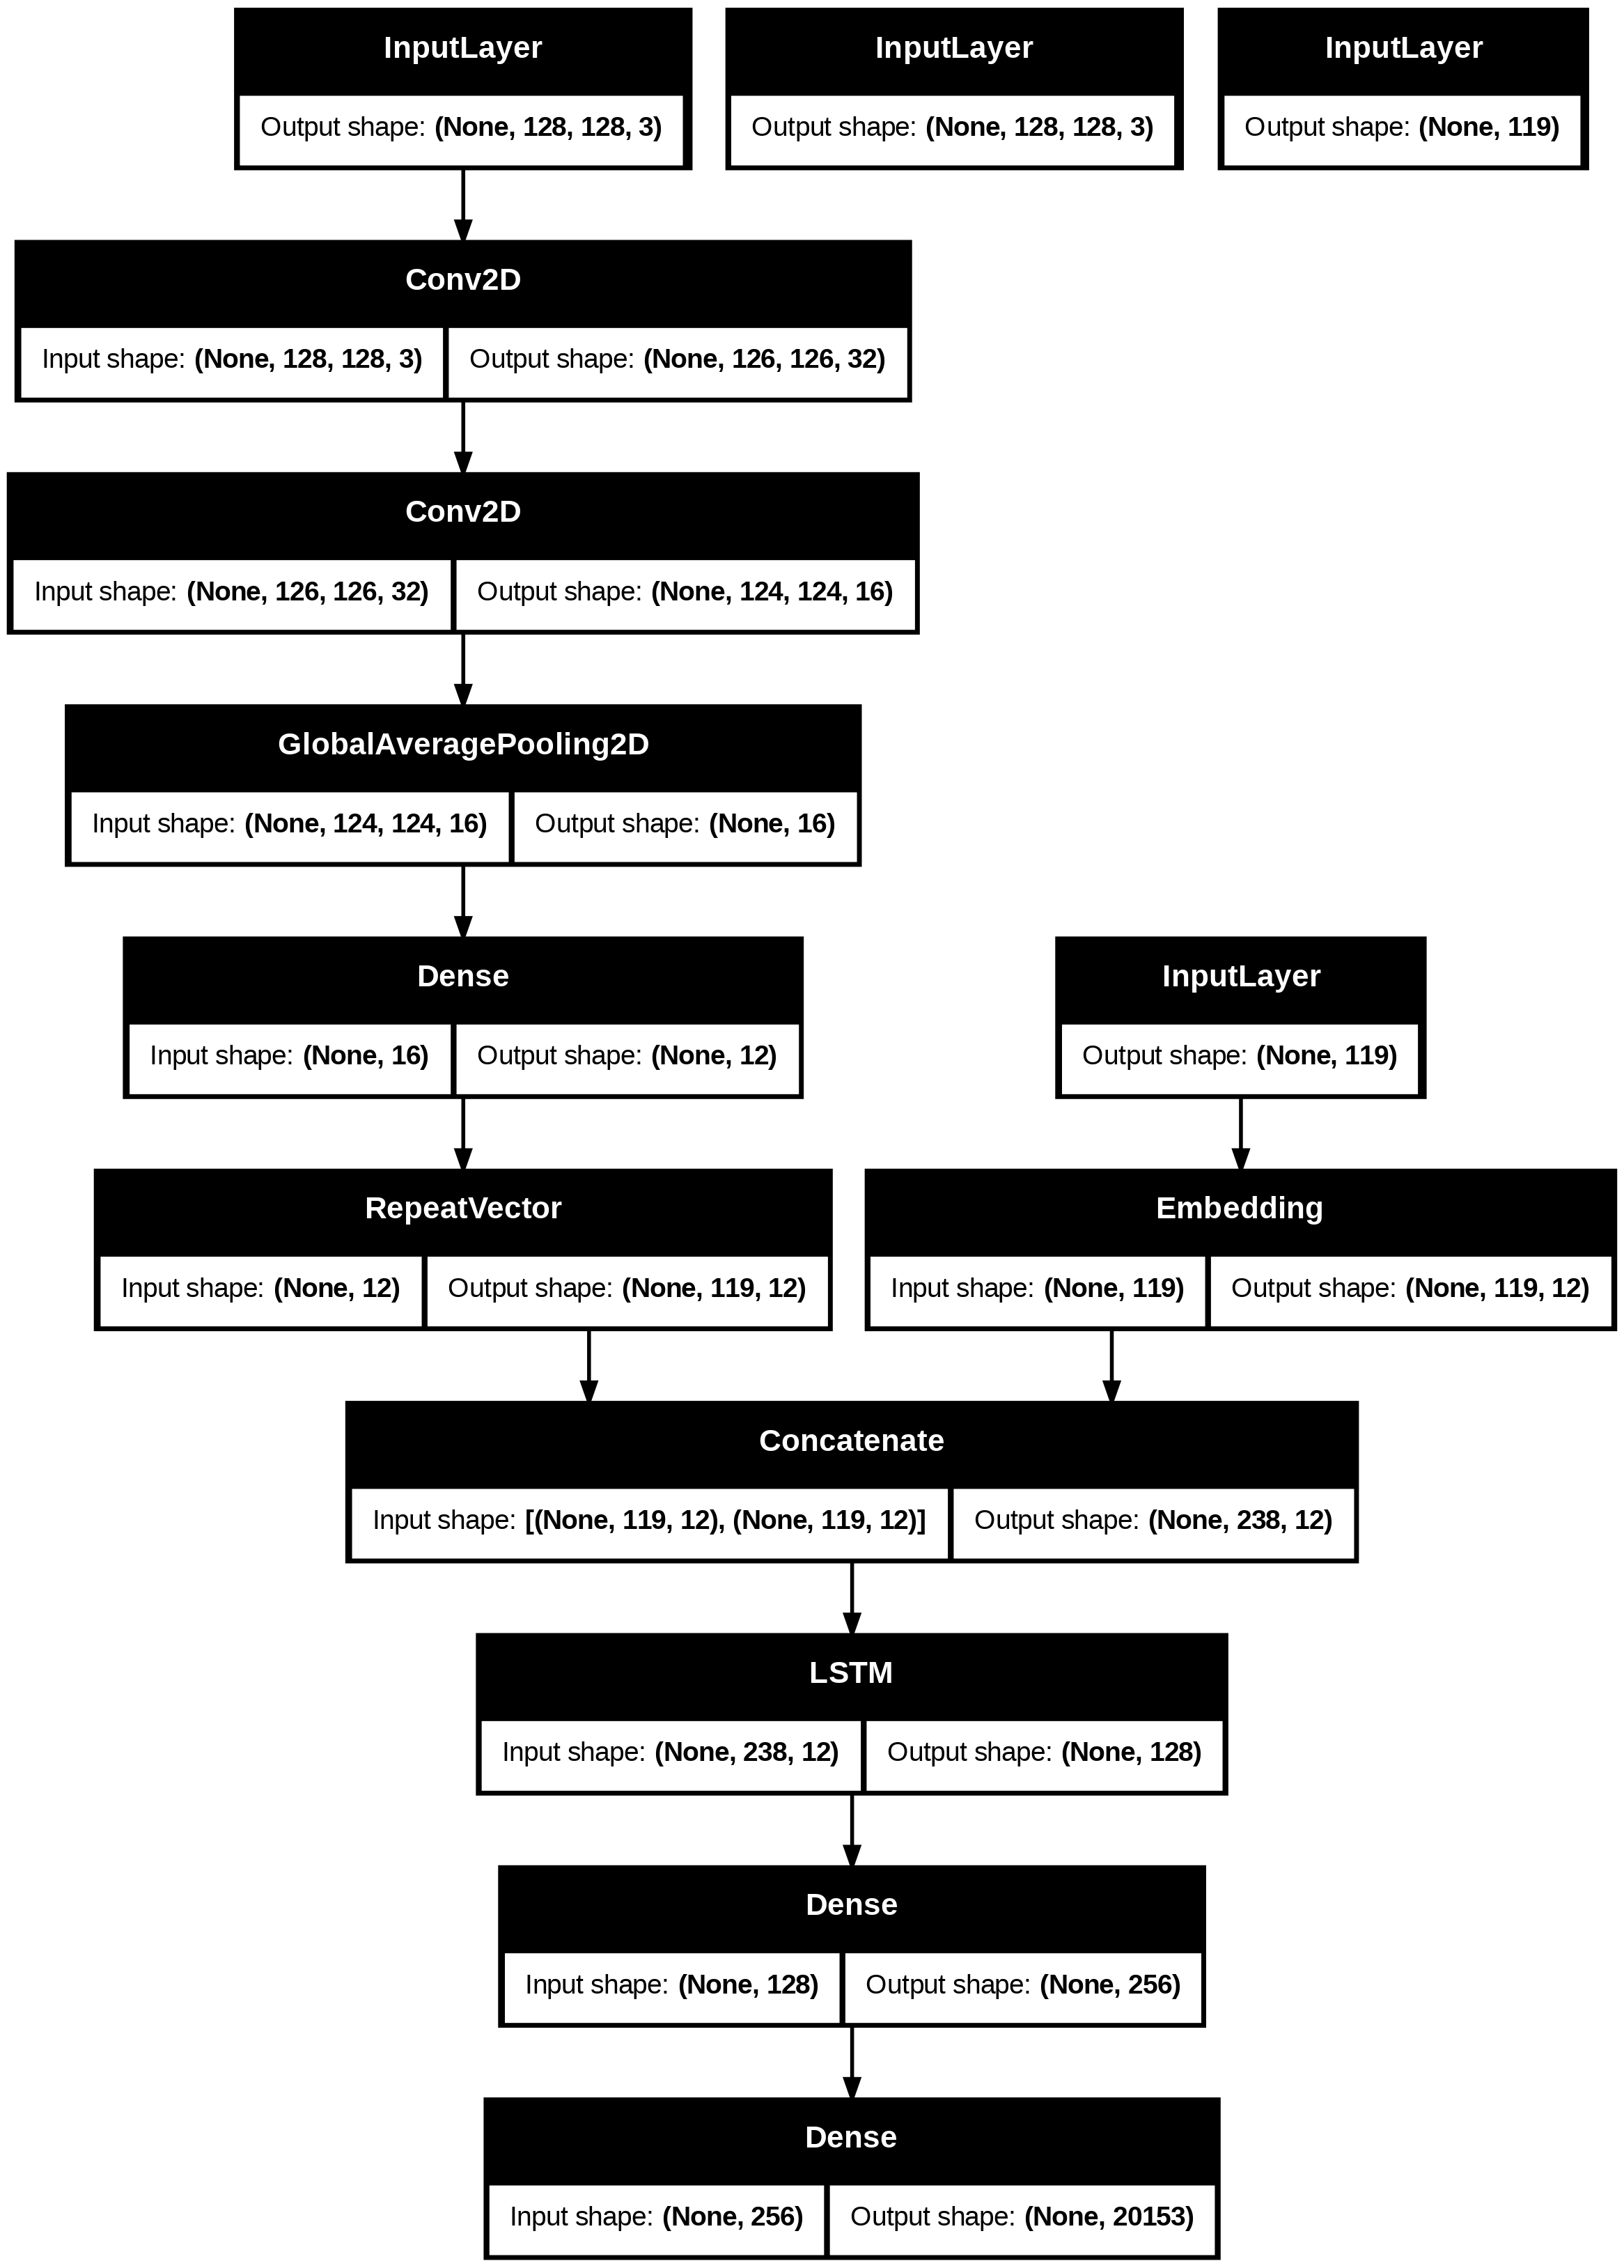

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
#Conv2D(32, 3, activation="relu")(train_generator[0][0])

In [ ]:
#Embedding(vocab_size, 12, mask_zero=True)(train_generator[0][1])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model2.fit(train_generator, epochs=5)

Epoch 1/5


KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m132013215082544\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=('tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)', 'tf.Tensor(shape=(None, 119), dtype=int64)')\n  • training=True\n  • mask=('None', 'None')"

###  VGG16 + LSTM

In [ ]:
flickr30k_df.head()

captions               sentids  \
0  [two young guys with shaggy hair look at their...       [0, 1, 2, 3, 4]   
1  [several men in hard hats are operating a gian...       [5, 6, 7, 8, 9]   
2  [a child in a pink dress is climbing up a set ...  [10, 11, 12, 13, 14]   
3  [someone in a blue shirt and hat is standing o...  [15, 16, 17, 18, 19]   
4  [two men one in a gray shirt one in a black sh...  [20, 21, 22, 23, 24]   

   split        filename  img_id  
0  train  1000092795.jpg       0  
1  train    10002456.jpg       1  
2  train  1000268201.jpg       2  
3  train  1000344755.jpg       3  
4  train  1000366164.jpg       4

In [ ]:
len(flickr30k_df)

31014

In [ ]:
def process_captions(captions):
  return str(captions[0][0])

In [ ]:

flickr30k_df['caption'] = flickr30k_df[['captions']].apply(process_captions, axis=1)
flickr30k_df.head()


<ipython-input-82-006753dda8c5>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return str(captions[0][0])


captions               sentids  \
0  [two young guys with shaggy hair look at their...       [0, 1, 2, 3, 4]   
1  [several men in hard hats are operating a gian...       [5, 6, 7, 8, 9]   
2  [a child in a pink dress is climbing up a set ...  [10, 11, 12, 13, 14]   
3  [someone in a blue shirt and hat is standing o...  [15, 16, 17, 18, 19]   
4  [two men one in a gray shirt one in a black sh...  [20, 21, 22, 23, 24]   

   split        filename  img_id  \
0  train  1000092795.jpg       0   
1  train    10002456.jpg       1   
2  train  1000268201.jpg       2   
3  train  1000344755.jpg       3   
4  train  1000366164.jpg       4   

                                             caption  
0  two young guys with shaggy hair look at their ...  
1  several men in hard hats are operating a giant...  
2  a child in a pink dress is climbing up a set o...  
3  someone in a blue shirt and hat is standing on...  
4  two men one in a gray shirt one in a black shi...

In [ ]:
print(flickr30k_df.dtypes)

captions    object
sentids     object
split       object
filename    object
img_id       int64
caption     object
dtype: object


In [ ]:
!pip install visualkeras


In [ ]:
#necessary preprocessing libraries:
from tqdm.notebook import tqdm
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import load_img, img_to_array
# The Tokenizer class has moved to tensorflow.keras.preprocessing.text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences # Moved to tensorflow.keras.utils
from tensorflow.keras.utils import to_categorical # Moved to tensorflow.keras.utils
from tensorflow.keras.models import Model # Moved to tensorflow.keras.models
from tensorflow.keras.utils import plot_model
import pickle
# layers:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten, add # Moved to tensorflow.keras.layers

In [ ]:
# function for image and label visualization

def display_images(temp_df):
    def readImage(path,img_size=224):
        img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
        img = img_to_array(img)
        img = img/255.
        return img
    from textwrap import wrap
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(5):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(os.path.join('/content/flickr30k-images',temp_df['filename'].iloc[i]))
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df['caption'].iloc[i], 20)))
        plt.axis("off")

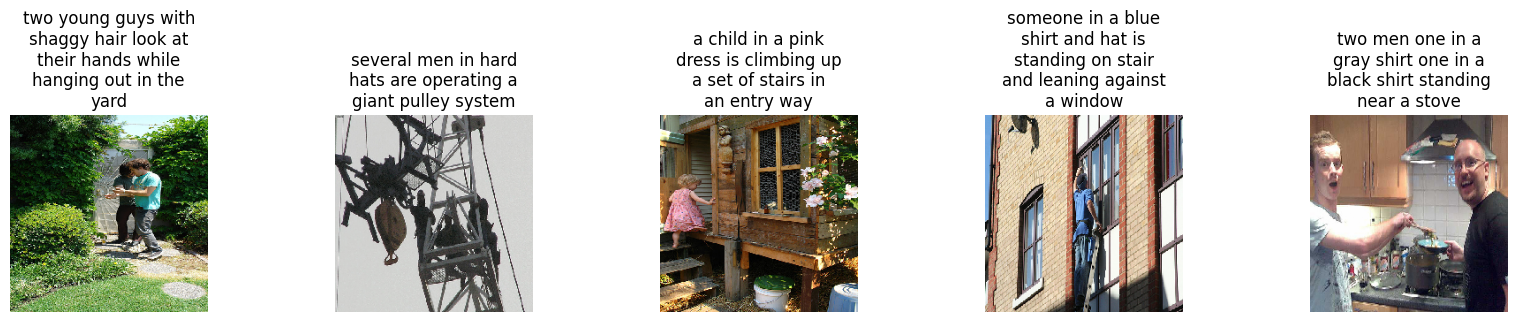

In [ ]:
display_images(flickr30k_df[['filename','caption']])

In [ ]:
img_model = VGG16()
# restructure the model (exclude the last dense layer):
img_model = Model(inputs = img_model.inputs, outputs = img_model.layers[-2].output)

display(img_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


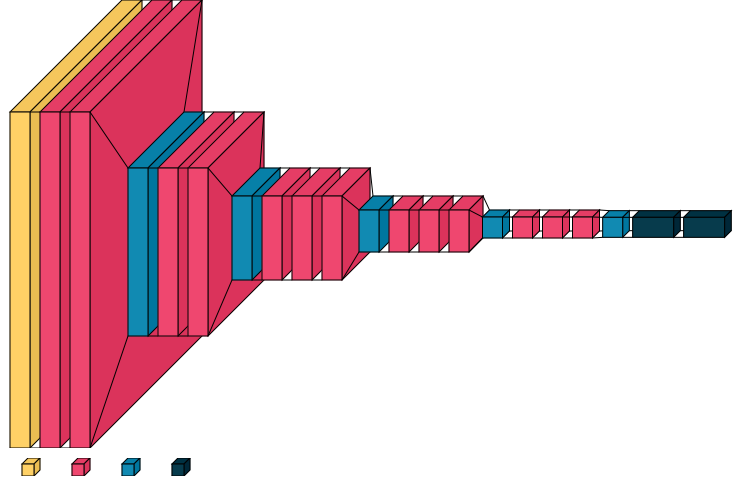

In [ ]:
import visualkeras
visualkeras.layered_view(img_model, draw_volume=True, scale_xy=1.5,scale_z=0.01, legend=True, type_ignore=[Flatten,Dropout])

In [ ]:
# function for feature extraction from images:
def feature_extraction(model,path,count=5000):
    features = {}
    img_size = 224
    total = 0

    for img_name in tqdm(os.listdir(path)):
        img_path = os.path.join(path,img_name)
        # load image from file
        try:
          img = load_img(img_path, target_size=(img_size,img_size))
        except:
          print('ERROR ' + img_path)
          continue
        # convert image to numpy array
        img = img_to_array(img)
        # reshape and preprocess image data for model
        img = np.expand_dims(img,axis=0)
        img = preprocess_input(img)
        # extract features
        feature = model.predict(img, verbose=0)
        # get image ID:
        img_id = img_name.split('.')[0]
        # store feature
        features[img_id]=feature
        total += 1
        if total == count:
          break
    return features

In [ ]:
%%time
BASE_DIR = '/content/'
path = os.path.join(BASE_DIR,'flickr30k-images')
features = feature_extraction(img_model,path)

  0%|          | 0/31784 [00:00<?, ?it/s]

In [ ]:
with open (os.path.join(BASE_DIR,'features_dict.pkl'),'wb') as f:
    pickle.dump(features,f)

In [ ]:
print(len(features))

500


In [ ]:
def clean_txt(text):
    import re
    text = str(text[0]).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub('#\S+','',text)
    text = re.sub(r'@\S+','', text)
    text = re.sub(r'[^A-Za-z]+',' ',text)
    text = re.sub(r'\s+',' ',text)
    text = 'stseq '+' '.join([word for word in text.split() if len(word)>1])+' enseq'
    return text

In [ ]:
def store_captions(data):
    captions={}
    for img_name,caption in tqdm(data.values):
        name = img_name.split('.')[0]
        if name not in captions:
          captions[name]=[] # as one image can have multiple captions
        captions[name].append(clean_txt(caption))
    return captions

In [ ]:
captions = store_captions(flickr30k_df[['filename', 'caption']])

  0%|          | 0/31014 [00:00<?, ?it/s]

In [ ]:
first_5_values = list(captions.values())[:5]
print(first_5_values)

[['stseq two young guys with shaggy hair look at their hands while hanging out in the yard enseq'], ['stseq several men in hard hats are operating giant pulley system enseq'], ['stseq child in pink dress is climbing up set of stairs in an entry way enseq'], ['stseq someone in blue shirt and hat is standing on stair and leaning against window enseq'], ['stseq two men one in gray shirt one in black shirt standing near stove enseq']]


In [ ]:
# saveing our captions dict
with open (os.path.join(BASE_DIR,'captions.pkl'),'wb') as f:
    pickle.dump(captions,f)

In [ ]:
corpus=[]
for img,data in captions.items():
    for line in data:
        corpus.append(line)

len(corpus)


31014

In [ ]:
corpus[:10]


['stseq two young guys with shaggy hair look at their hands while hanging out in the yard enseq',
 'stseq several men in hard hats are operating giant pulley system enseq',
 'stseq child in pink dress is climbing up set of stairs in an entry way enseq',
 'stseq someone in blue shirt and hat is standing on stair and leaning against window enseq',
 'stseq two men one in gray shirt one in black shirt standing near stove enseq',
 'stseq two people in the photo are playing the guitar and the other is poking at him enseq',
 'stseq man sits in chair while holding large stuffed animal of lion enseq',
 'stseq girl is on rollerskates talking on her cellphone standing in parking lot enseq',
 'stseq an asian man wearing black suit stands near dark haired woman and brown haired woman enseq',
 'stseq two men in germany jumping over rail at the same time without shirts enseq']

In [ ]:
tok = Tokenizer()
tok.fit_on_texts(corpus)

vocab_size = len(tok.word_index)+1
print(f"Vocab size: {vocab_size}")


Vocab size: 12084


In [ ]:
# get max length of the captions:
max_len = max(len(cap.split()) for cap in corpus)
print(max_len)


74


In [ ]:
img_id = list(captions.keys())
split = int(len(img_id)*0.9)

train = img_id[:split]
test = img_id[split:]

print(len(train))
print(len(test))

27912
3102


In [ ]:
# create a data generator function to get data in batch (avoids session crash)
# this data generator will tokenize and pad the captions in itself and will yield the
def dataGenerator(data_keys,captions,features,tokenizer,max_len,vocab_size,batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            data = captions[key]
            for caption in data:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split seq into X,y pairs
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input seq:
                    in_seq = pad_sequences([in_seq], maxlen=max_len, padding='post')[0]
                    # encode output seq:
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1, X2, y = np.array(X1),np.array(X2),np.array(y)
                yield [X1,X2],y
                X1,X2,y = list(),list(),list()
                n=0

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 74)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 4096)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 74, 256)        │      3,093,504 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 4096)           │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 74, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 74)             │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      1,048,832 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ dropout_1[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 12084)          │      3,105,588 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,839,028 (29.90 MB)

 Trainable params: 7,839,028 (29.90 MB)

 Non-trainable params: 0 (0.00 B)

None
CPU times: user 188 ms, sys: 15.2 ms, total: 203 ms
Wall time: 546 ms


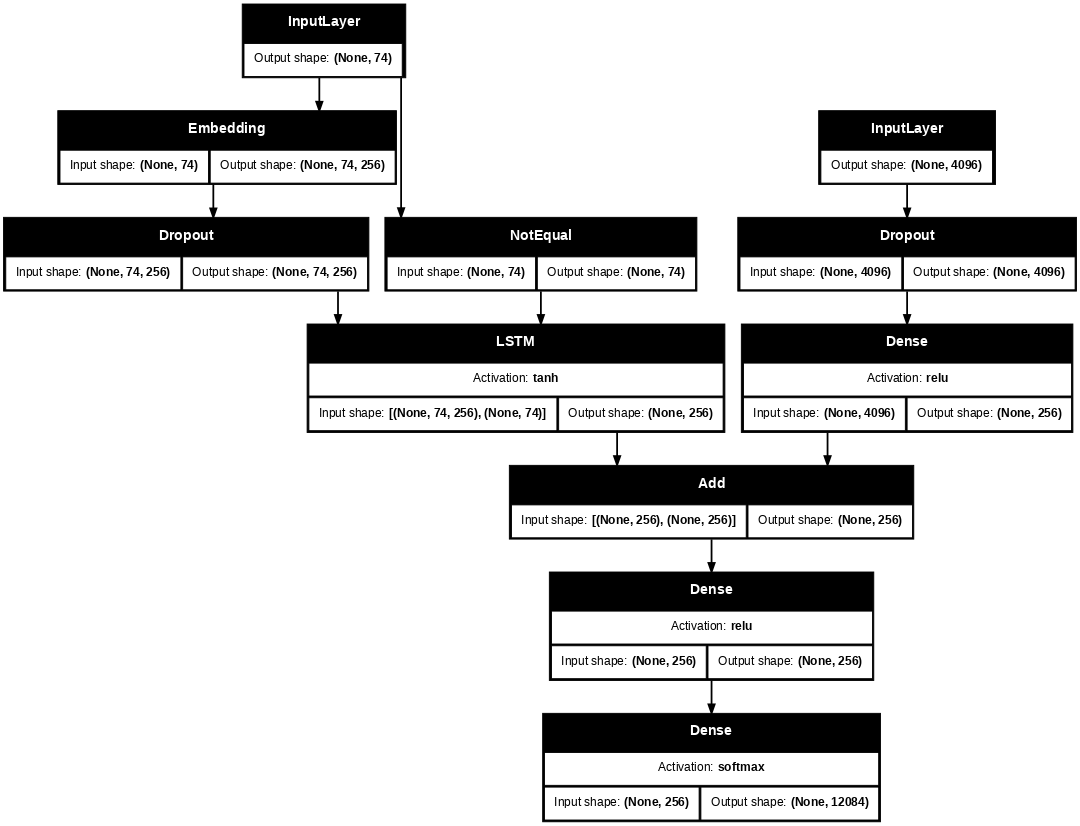

In [ ]:
%%time
# encoder model:

# image feature layers
input1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(input1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
input2 =Input(shape=(max_len,))
se1 = Embedding(vocab_size,256,mask_zero=True)(input2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


# decoder model
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1,input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# show summary
print(model.summary())

# plot the model
os.chdir(BASE_DIR)
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True, dpi=64)


In [ ]:
%%time
import keras
import tensorflow as tf # import tensorflow

# Training the model:
epochs = 15
batch_size = 64
steps = len(train)//batch_size

es = keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=4)
for i in range(epochs):
    # Create tf.data.Dataset from generator
    dataset = tf.data.Dataset.from_generator(
        lambda: dataGenerator(train, captions, features, tok, max_len, vocab_size, batch_size),
        output_types=([tf.float32, tf.int32], tf.float32), # Specify output types
        output_shapes=([ (None, 4096), (None, max_len)], (None, vocab_size)) # Specify output shapes
    )
    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size) #buffer size 1024
    # Fit the model using the dataset
    model.fit(dataset, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[es])

TypeError: Dimension value must be integer or None or have an __index__ method, got value '(None, 4096)' with type '<class 'tuple'>'

In [ ]:
import numpy as np
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

# Define constants
MAX_SEQUENCE_LENGTH = 74  # Maximum caption length
VOCAB_SIZE = 10000        # Vocabulary size
EMBEDDING_DIM = 256       # Embedding dimension
LSTM_UNITS = 256          # LSTM units
BATCH_SIZE = 64

# Load pre-trained VGG16 model (without top layers)
vgg_model = VGG16(weights='imagenet')
vgg_model = Model(inputs=vgg_model.input, outputs=vgg_model.layers[-2].output)  # Extract features from the second last layer

def preprocess_image(img_path):
    """Preprocess the image using VGG16."""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

def extract_features(directory, count=31015):
    """Extract features from all images in the directory using VGG16."""
    features = {}
    total = 0
    for img_name in tqdm(os.listdir(directory)):
        img_path = os.path.join(directory, img_name)
        try:
          img_array = preprocess_image(img_path)
        except:
          print('ERROR ' + img_path)
          continue
        #img_array = preprocess_image(img_path)
        feature = vgg_model.predict(img_array, verbose=0)
        features[img_name] = feature.flatten()
        total +=1
        if total == count:
          break
    return features

image_features = extract_features('/content/flickr30k-images/')


 27%|██▋       | 8677/31784 [13:21<32:31, 11.84it/s]

ERROR /content/flickr30k-images/readme.txt


 98%|█████████▊| 31015/31784 [48:11<01:11, 10.73it/s]


In [ ]:
def build_tokenizer(captions):
    """Create a tokenizer and fit it on the captions."""
    all_captions = []
    for caption_list in captions.values():
        all_captions.extend(caption_list)

    tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<UNK>')
    tokenizer.fit_on_texts(all_captions)
    return tokenizer

# Load captions (adjust file path)
tokenizer = build_tokenizer(captions)
word_index = tokenizer.word_index

# Encode captions
def encode_captions(captions):
    """Encode captions using the tokenizer."""
    encoded_captions = {}
    for img_name, caption_list in captions.items():
        encoded_captions[img_name] = tokenizer.texts_to_sequences(caption_list)
    return encoded_captions

encoded_captions = encode_captions(captions)


In [ ]:
first_5_encoded_captions = list(encoded_captions.values())[:5]
print(first_5_encoded_captions)

[[[2, 19, 27, 500, 7, 1967, 70, 162, 23, 60, 130, 20, 318, 86, 4, 5, 545, 3]], [[2, 110, 36, 4, 334, 250, 17, 1569, 798, 3436, 2245, 3]], [[2, 74, 4, 76, 102, 10, 317, 52, 342, 9, 478, 4, 22, 2949, 571, 3]], [[2, 285, 4, 21, 13, 6, 54, 10, 29, 8, 2950, 6, 322, 197, 239, 3]], [[2, 19, 36, 28, 4, 87, 13, 28, 4, 18, 13, 29, 100, 1399, 3]]]


In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Add
from tensorflow.keras.models import Model

# Embedding layer for captions
caption_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
caption_embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True)(caption_input)
caption_lstm = LSTM(LSTM_UNITS)(caption_embedding)

# Image feature extraction input
image_input = Input(shape=(4096,))  # 4096 is the output size from VGG16's second last layer
image_dense = Dense(LSTM_UNITS, activation='relu')(image_input)
image_dropout = Dropout(0.5)(image_dense)

# Combine image and caption embeddings
merged = Add()([caption_lstm, image_dropout])
output = Dense(VOCAB_SIZE, activation='softmax')(merged)

# Build model
model = Model(inputs=[image_input, caption_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 74)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, 4096)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 74, 256)        │      2,560,000 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 74)             │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 256)            │      1,048,832 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 256)            │        525,312 │ embedding_2[0][0],     │
│                           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256)            │              0 │ lstm_2[0][0],          │
│                           │                        │                │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 10000)          │      2,570,000 │ add_2[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,704,144 (25.57 MB)

 Trainable params: 6,704,144 (25.57 MB)

 Non-trainable params: 0 (0.00 B)

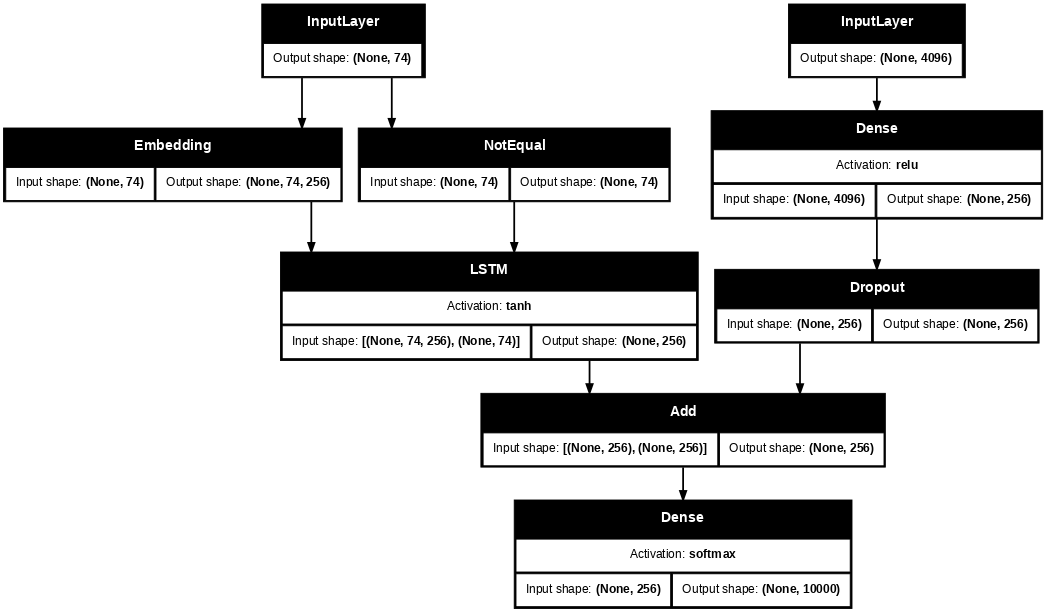

In [ ]:
# plot the model
os.chdir(BASE_DIR)
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True, dpi=64)

In [ ]:
image_features['1000092795.jpg']

array([3.8965464, 3.8461807, 0.       , ..., 0.       , 0.6352433,
       1.1605129], dtype=float32)

In [ ]:
encoded_captions['1000092795']

[[2, 19, 27, 500, 7, 1967, 70, 162, 23, 60, 130, 20, 318, 86, 4, 5, 545, 3]]

In [ ]:
# Prepare data generator
def data_generator(image_features, encoded_captions, tokenizer, batch_size=BATCH_SIZE):
    """Generator to yield training data in batches."""
    x_image, x_caption, y = [], [], []

    while True:
        for img_name, encoded_list in encoded_captions.items():
            for encoded_caption in encoded_list:
                for i in range(1, len(encoded_caption)):
                    # Split input and output sequences
                    input_seq = encoded_caption[:i]
                    output_seq = encoded_caption[i]

                    # Pad input sequences
                    input_seq = pad_sequences([input_seq], maxlen=MAX_SEQUENCE_LENGTH, padding='post')[0]

                    # Create training data
                    x_image.append(image_features[img_name])
                    x_caption.append(input_seq)
                    y.append(to_categorical(output_seq, num_classes=VOCAB_SIZE))

                    # Yield batch
                    if len(x_image) >= batch_size:
                        yield [np.array(x_image), np.array(x_caption)], np.array(y)
                        x_image, x_caption, y = [], [], []

# Train the model
train_generator = data_generator(image_features, encoded_captions, tokenizer, batch_size=BATCH_SIZE)
model.fit(train_generator, epochs=20, steps_per_epoch=1000)

NameError: name 'BATCH_SIZE' is not defined

In [ ]:
import tensorflow as tf # Import tensorflow
from tensorflow.keras.utils import to_categorical # Import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import pad_sequences
import numpy as np # Import numpy

# Prepare data generator
def data_generator(image_features, encoded_captions, tokenizer, batch_size=32):  # Changed to default batch_size=32
    """Generator to yield training data in batches."""
    while True:
        x_image, x_caption, y = [], [], []
        for img_name, encoded_list in encoded_captions.items():
            img_name = img_name + '.jpg'
            for encoded_caption in encoded_list:
                for i in range(1, len(encoded_caption)):
                    input_seq = encoded_caption[:i]
                    output_seq = encoded_caption[i]
                    input_seq = pad_sequences([input_seq], maxlen=100, padding='post')[0]  # Assumed MAX_SEQUENCE_LENGTH = 100
                    try:
                        x_image.append(image_features[img_name])
                    except:
                        print('ERROR ' + img_name)
                        continue
                    x_caption.append(input_seq)
                    y.append(to_categorical(output_seq, num_classes=1000))  # Assumed VOCAB_SIZE = 1000
                    if len(x_image) >= batch_size:
                        yield ([np.array(x_image), np.array(x_caption)], np.array(y))
                        x_image, x_caption, y = [], [], []
# Define output signature for the generator
output_signature = (
    (tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  # Assuming image features are 4096-dimensional float32
     tf.TensorSpec(shape=(None, 100), dtype=tf.int32)),   # Assuming captions are padded to 100 with int32 tokens
    tf.TensorSpec(shape=(None, 1000), dtype=tf.float32)  # Assuming one-hot encoded targets with VOCAB_SIZE = 1000
)
# Train the model
# Ensure `data_generator` is called with parentheses to get a generator object
train_generator = data_generator(image_features, encoded_captions, tokenizer, batch_size=32) # Changed to default batch_size=32
train_dataset = tf.data.Dataset.from_generator(train_generator, output_signature=output_signature)
model.fit(train_dataset, epochs=20, steps_per_epoch=1000)

TypeError: `generator` must be a Python callable.

#### Caption Tokenization and Encoding

In [ ]:
# Define a class that creates a custom caption encoder object that handles tokenizing and
# encoding/decoding a set of captions
class CustomCaptionEncoder(CaptionEncoder):
  def __init__(self, vocab, seq_length):
    # Set the vocabulary, vocabulary size, and length of the sequences
    self.vocab = vocab
    self.vocab_size = len(vocab)
    self.seq_length = seq_length

    # Define mappings for token to id and id to token
    # ID 0 is reserved for padding
    self.token_to_id = {token: id+1 for id, token in enumerate(vocab)}
    self.id_to_token = {id: token for token, id in self.token_to_id.items()}

  def encode(self, caption):
    # Add the start sequence token to the beginning on the caption tokens
    caption_tokens = ["<START>"] + word_tokenize(caption)

    # Convert each token to its id
    encoding = [self.token_to_id[token] for token in caption_tokens]

    # If the sequence is too short, pad it to the sequence length
    if len(encoding) < self.seq_length-1:
      padding = [0] * (self.seq_length - 1 - len(encoding))
      encoding.extend(padding)
    # If the sequence is too long, truncate it to the sequence length
    else:
      encoding = encoding[:self.seq_length-1]

    # Add the end sequence token
    end_token = self.token_to_id["<END>"]
    encoding.extend([end_token])

    return encoding

  def decode(self, encoding):
    # Convert the encoding back into tokens
    return [self.id_to_token[id] for id in encoding if id != 0]

In [ ]:
# Define a class that builds a data generator object for dynamically loading data
class CustomDataGenerator(DataGenerator):
  def __init__(self, df, caption_encoder, im_width, im_height, batch_size=32, shuffle=True):
    self.data = df
    self.caption_encoder = caption_encoder
    self.im_width = im_width
    self.im_height = im_height
    self.batch_size = batch_size
    self.shuffle = shuffle

  # Customizes the object accessor [] to retrieve the batch at a particular index
  def __getitem__(self, idx):

    # Get the range of indices for this batch
    low = idx * self.batch_size
    high = min(low + self.batch_size, len(self.data))

    # Retrieve the batch
    batch = self.data[low:high]

    images = batch["image"]
    batch_captions = batch["captions"]
    caption_sequences = []
    y = []
    image_tensors = []

      # For each image, normalize its pixel values and resize it
    for img in images:
      img_tensor = tf.convert_to_tensor(img)
      img_tensor = tf.image.resize(img_tensor, [self.im_width, self.im_height])
      img_tensor = img_tensor/255.0
      image_tensors.append(img_tensor)

    for captions in batch_captions:
      caption_idx = random.randint(0, 4)
      caption = captions[caption_idx]
      encoding = self.caption_encoder.encode(caption)

      for i in range(1, len(encoding)):
          # Create input and output sequences from the captions, e.g.
          # <START> -> a
          # <START> a -> sample
          # <START> a sample -> caption
        caption_input, output = encoding[:i], encoding[i]
        padding = [0] * (self.caption_encoder.seq_length - 1 - len(caption_input))
        caption_input.extend(padding)
        output = to_categorical([output], num_classes=self.caption_encoder.vocab_size)
        caption_sequences.append(caption_input)
        y.append(output)
        # image_tensors.append(img_tensor)

        #image_captions.append(encoding)
    y = np.array(y).reshape(-1, self.caption_encoder.vocab_size)

    # Return a batch of images and captions
    return (np.array(image_tensors), np.array(caption_sequences)), y

  # Customize built in len() method to return the number of batches per epoch
  def __len__(self):
    return int(np.ceil(len(self.data) / float(self.batch_size)))

  # If shuffle is enabled, shuffle the data at the end of each epoch
  def on_epoch_end(self):
    if self.shuffle:
      self.data = self.data.sample(frac=1).reset_index(drop=True)

  # Helper function to load and preprocess an image from disk
  def load_image_from_file(self, filename):
    img = Image.open(f"flickr30k-images/{filename}")
    img_tensor = tf.convert_to_tensor(img)
    img_tensor = tf.image.resize(img_tensor, [128, 128])
    img_tensor = img_tensor/255.0
    return img_tensor

In [ ]:
custom_caption_encoder = CustomCaptionEncoder(full_vocab, 120)

NameError: name 'full_vocab' is not defined

In [ ]:
# Instantiate generators for each data split
im_width = 128
im_height = 128
batch_size = 32

train_generator = DataGenerator(train_df, custom_caption_encoder, im_width, im_height, batch_size=batch_size)
test_generator = DataGenerator(test_df, custom_caption_encoder, im_width, im_height, batch_size=batch_size)
val_generator = DataGenerator(val_df, custom_caption_encoder, im_width, im_height, batch_size=batch_size)

NameError: name 'custom_caption_encoder' is not defined

### ResNet v2 + GPT2

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, GlobalAveragePooling2D, Attention
from tensorflow.keras.models import Model

from transformers import TFGPT2LMHeadModel, AutoTokenizer
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

keras.callbacks.

In [55]:
# Load and preprocess the image
filename = train_df['filename'][2]
img = image.load_img(f"flickr30k-images/{filename}", target_size=(224, 224))
x = image.img_to_array(img)
print(x.shape)
x = np.expand_dims(x, axis=0)
print(x.shape)

# preprocess_input applies a series of transformations to the image,
# such as normalizing the pixel values to be between -1 and 1 and zero-centering the data.
# needed to match pre-trained model trained format
x = preprocess_input(x)
print(x.shape)

(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


In [56]:
# Load the ResNet50 model
res_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [49]:
# Use the model to classify the image
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

decoded_predictions = decode_predictions(preds)[0]
print("decoded predictions:", decoded_predictions)
print("length of predictions:", len(decoded_predictions))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted: [('n02727426', 'apiary', 0.28241983), ('n03899768', 'patio', 0.16586067), ('n03991062', 'pot', 0.075091034)]
decoded predictions: [('n02727426', 'apiary', 0.28241983), ('n03899768', 'patio', 0.16586067), ('n03991062', 'pot', 0.075091034), ('n02699494', 'altar', 0.053625077), ('n03776460', 'mobile_home', 0.052462194)]
length of predictions: 5


In [52]:
def get_image_features(decode_predictions):
  feature_names = []
  for i in range(len(decoded_predictions)):
    feature_names.append(decoded_predictions[i][1])

  return feature_names

['apiary', 'patio', 'pot', 'altar', 'mobile_home']


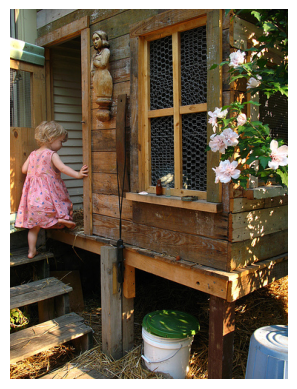

In [53]:
features = get_image_features(decoded_predictions)
print(features)
img = Image.open(f"flickr30k-images/{filename}")
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
for layer in res_model.layers[:143]:
    layer.trainable = False



In [58]:
len(res_model.layers)

175

In [59]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="cifar10.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

NameError: name 'keras' is not defined

In [ ]:
model_checkpoint = "distilgpt2"
# Load GPT-2 model and tokenizer
gpt2_model = TFGPT2LMHeadModel.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# gp2_model = GPT2LMHeadModel.from_pretrained('gpt2')
word_embeddings = gp2_model.transformer.wte.weight # Word Token Embeddings
print(word_embeddings.shape)
print(tokenizer)


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

torch.Size([50257, 768])
GPT2TokenizerFast(name_or_path='distilgpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}


In [ ]:
print("caption ex:", train_df['captions'][0][0])
def tokenize_function(train_df):
    return tokenizer(train_df['captions'][0][0])

print(tokenize_function(train_df))

caption ex: Two young guys with shaggy hair look at their hands while hanging out in the yard.
{'input_ids': [7571, 1862, 3730, 351, 427, 363, 1360, 4190, 804, 379, 511, 2832, 981, 10938, 503, 287, 262, 12699, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


#### Caption Encoder

In [ ]:
class GPT2CaptionEncoder(CaptionEncoder):
  def __init__(self, vocab, seq_length):
    # Set the vocabulary, vocabulary size, and length of the sequences
    self.vocab = vocab
    self.vocab_size = len(vocab)
    self.seq_length = seq_length

    # Define mappings for token to id and id to token
    # ID 0 is reserved for padding
    self.token_to_id = {token: id+1 for id, token in enumerate(vocab)}
    self.id_to_token = {id: token for token, id in self.token_to_id.items()}

  def encode(self, caption):
    # Add the start sequence token to the beginning on the caption tokens
    caption_tokens = ["<START>"] + word_tokenize(caption)

    print(caption_tokens)
    # Convert each token to its id
    encoding = [self.token_to_id[token] for token in caption_tokens]

    # If the sequence is too short, pad it to the sequence length
    if len(encoding) < self.seq_length-1:
      padding = [0] * (self.seq_length - 1 - len(encoding))
      encoding.extend(padding)
    # If the sequence is too long, truncate it to the sequence length
    else:
      encoding = encoding[:self.seq_length-1]

    # Add the end sequence token
    end_token = self.token_to_id["<END>"]
    encoding.extend([end_token])

    return encoding

  def decode(self, encoding):
    # Convert the encoding back into tokens
    return [self.id_to_token[id] for id in encoding if id != 0]


In [ ]:
gp2_caption_encoder = GPT2CaptionEncoder(full_vocab, 120)

#### GPT2 Data Generator

In [ ]:
class DataGeneratorGPT2(tf.keras.utils.Sequence):
  def __init__(self, df, caption_encoder, im_width, im_height, batch_size=32, shuffle=True):
    self.data = df
    self.caption_encoder = caption_encoder
    self.im_width = im_width
    self.im_height = im_height
    self.batch_size = batch_size
    self.shuffle = shuffle

  # Customizes the object accessor [] to retrieve the batch at a particular index
  def __getitem__(self, idx):

    # Get the range of indices for this batch
    low = idx * self.batch_size
    high = min(low + self.batch_size, len(self.data))

    # Retrieve the batch
    batch = self.data[low:high]
    images = batch["filename"]
    batch_captions = batch["captions"]
    caption_sequences = []
    y = []
    image_tensors = []

      # For each image, normalize its pixel values and resize it
    for img in images:
      img_tensor = self.load_image_from_file(img)
      image_tensors.append(img_tensor)

    print("finished normalization")
    for captions in batch_captions:
      caption_idx = random.randint(0, 4)
      caption = captions[caption_idx]
      encoding = self.caption_encoder.encode(caption)

      for i in range(1, len(encoding)):
          # Create input and output sequences from the captions, e.g.
          # <START> -> a
          # <START> a -> sample
          # <START> a sample -> caption
        caption_input, output = encoding[:i], encoding[i]
        padding = [0] * (self.caption_encoder.seq_length - 1 - len(caption_input))
        caption_input.extend(padding)
        output = to_categorical([output], num_classes=self.caption_encoder.vocab_size)
        caption_sequences.append(caption_input)
        y.append(output)
        # image_tensors.append(img_tensor)

        #image_captions.append(encoding)

    print("finished caption encoding")
    y = np.array(y).reshape(-1, self.caption_encoder.vocab_size)

    # Return a batch of images and captions
    return (np.array(image_tensors), np.array(caption_sequences)), y

    # # Return a batch of images and captions
    # return np.array(image_tensors) #, np.array(image_captions)

  # Customize built in len() method to return the number of batches per epoch
  def __len__(self):
    return int(np.ceil(len(self.data) / float(self.batch_size)))

  # If shuffle is enabled, shuffle the data at the end of each epoch
  def on_epoch_end(self):
    if self.shuffle:
      self.data = self.data.sample(frac=1).reset_index(drop=True)

  # Helper function to load and preprocess an image from disk
  def load_image_from_file(self, filename):
    img = Image.open(f"flickr30k-images/{filename}")
    img_tensor = tf.convert_to_tensor(img)
    img_tensor = tf.image.resize(img_tensor, [128, 128])
    img_tensor = img_tensor/255.0

    # img = image.load_img(f"flickr30k-images/{filename}", target_size=(224, 224))
    # x = image.img_to_array(img)
    # x = np.expand_dims(x, axis=0)
    # x = preprocess_input(x)

    return img_tensor

In [ ]:
# Instantiate generators for each data split
im_width = 128
im_height = 128
batch_size = 32

train_generator = DataGeneratorGPT2(train_df, gp2_caption_encoder, im_width, im_height, batch_size=batch_size)
# test_generator = DataGeneratorGPT2(test_df, gp2_caption_encoder, im_width, im_height, batch_size=batch_size)
# val_generator = DataGeneratorGPT2(val_df, gp2_caption_encoder, im_width, im_height, batch_size=batch_size)

In [ ]:
img_batch, input_sequences_batch, output_sequences_batch = train_generator[0]
print(f"Images shape: {img_batch.shape}")
print(f"Caption input shape: {input_sequences_batch.shape}")
print(f"Ground truth shape: {output_sequences_batch.shape}")
print(f"Generator Length: {len(train_generator)}")

finished normalization
['<START>', 'Two', 'friends', 'enjoy', 'time', 'spent', 'together', '.']


KeyError: 'Two'

In [ ]:
caption = caption_batch[0]
decode_batch_caption = caption_encoder.decode(caption_batch[0])
print(decode_batch_caption)

tokenizer.add_special_tokens({'pad_token': '[PAD]'})
gpt_encoded_caption = tokenizer.encode(decode_batch_caption, max_length=120, padding='max_length', truncation=True)
print(gpt_encoded_caption)
print(len(gpt_encoded_caption))

['<START>', 'Two', 'men', 'in', 'green', 'shirts', 'are', 'standing', 'in', 'a', 'yard', '.', '<END>']
[50256, 7571, 3653, 259, 14809, 23231, 533, 5646, 259, 64, 9413, 13, 50256, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257]
120


In [ ]:
class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, vocab_size, max_caption_length=120, cnn_input_shape=(224, 224, 3)):
        super(ImageCaptioningModel, self).__init__()

        # Load the pre-trained GPT-2 model
        self.gpt2_model = TFGPT2LMHeadModel.from_pretrained("gpt2")
        for layer in self.gpt2_model.layers:
            layer.trainable = False  # Optionally freeze GPT-2 layers

        # Define the CNN for image feature extraction
        self.image_input = Input(shape=cnn_input_shape, name="image_input")
        self.caption_input = Input(shape=(max_caption_length,), dtype=tf.int32, name="caption_input")

        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation="relu")
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")
        self.pool2 = tf.keras.layers.GlobalAveragePooling2D()
        self.dense_cnn = Dense(256, activation="relu")
        self.dropout_cnn = Dropout(0.5)

        # Projection to GPT-2 embedding space
        self.image_projection = Dense(50257, activation="relu")
        self.caption_projection = Dense(50257, activation="relu")


        # Add a dense layer to project GPT-2 outputs to match the CNN feature dimension
        # self.caption_projection = Dense(256, activation="relu")

        # Define dense layers for combining CNN and GPT-2 features
        self.concat = Concatenate(axis=1)
        self.dense_combined = Dense(256, activation="relu")
        self.dropout_combined = Dropout(0.5)
        self.output_layer = Dense(vocab_size, activation="softmax")

    def call(self, inputs):
        # Split inputs into image and caption parts
        image, caption = inputs

        # CNN forward pass
        x = self.conv1(image)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        image_features = self.dense_cnn(x)
        image_features = self.dropout_cnn(image_features)

        print('image features after cnn', image_features.shape)
        print('caption original shape', caption.shape)
        # Project image features to match GPT-2 embedding size
        image_features = self.image_projection(image_features)

        # Pass caption through GPT-2 model
        gpt2_outputs = self.gpt2_model(caption)
        print(type(gpt2_outputs))
        caption_logits = gpt2_outputs.logits
        print("caption logit shape", caption_logits.shape)

        caption_features = Dense(256, activation="relu")(caption_logits)
        caption_features = tf.reduce_mean(caption_features, axis=1)  # (64, 256)
        print("after caption features Dense 256 and reduce mean - img shape: ", image_features.shape, "caption shape", caption_features.shape)

        combined_features = self.concat([image_features, caption_features])  # (64, 512)
        print("originally combined features", combined_features.shape)
        # Process combined features with a dense layer
        combined_features = self.dense_combined(combined_features)
        combined_features = self.dropout_combined(combined_features)
        print("after dense and dropout combined features", combined_features.shape)
        # Output prediction for each word in the sequence
        output = self.output_layer(combined_features)
        return output

In [ ]:
# Set vocabulary size and other hyperparameters
vocab_size = tokenizer.vocab_size
max_caption_length = 120

# Instantiate and compile the model
model = ImageCaptioningModel(vocab_size=vocab_size, max_caption_length=max_caption_length)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
# 4. Invoke the model
input_data = (img_batch, caption_batch)
print("img shape:", input_data[0].shape, "caption shape", input_data[1].shape)

predictions = model(input_data)
print(predictions.shape)
print(predictions[0])

# Decode the full sequence of indices to get the generated caption for each image
predicted_captions = []
for sequence in predictions:
    # Decode the full sequence of word indices into a single caption string
    caption = tokenizer.decode(sequence, skip_special_tokens=True)  # Skip special tokens like padding
    predicted_captions.append(caption)

img shape: (64, 224, 224, 3) caption shape (64, 120)
image features after cnn (64, 256)
caption original shape (64, 120)
<class 'transformers.modeling_tf_outputs.TFCausalLMOutputWithCrossAttentions'>
caption logit shape (64, 120, 50257)
after caption features Dense 256 and reduce mean - img shape:  (64, 50257) caption shape (64, 256)
originally combined features (64, 50513)
after dense and dropout combined features (64, 256)
image features after cnn (64, 256)
caption original shape (64, 120)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'image_captioning_model_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


<class 'transformers.modeling_tf_outputs.TFCausalLMOutputWithCrossAttentions'>
caption logit shape (64, 120, 50257)
after caption features Dense 256 and reduce mean - img shape:  (64, 50257) caption shape (64, 256)
originally combined features (64, 50513)
after dense and dropout combined features (64, 256)
(64, 50257)
tf.Tensor(
[1.3851303e-06 4.9406035e-06 1.9392479e-05 ... 3.3863493e-05 1.1885997e-05
 6.5515314e-06], shape=(50257,), dtype=float32)


In [ ]:
print(predictions[1])
print(predicted_captions[1])

tf.Tensor(
[1.2256218e-05 2.0172381e-05 7.4289951e-06 ... 2.9406901e-05 5.2711648e-06
 1.3736330e-06], shape=(50257,), dtype=float32)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
# Plot the images with their captions
num_samples = 5
plt.figure(figsize=(15, 6))
for i in range(min(num_samples, len(img_batch))):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img_batch[i])
    plt.axis('off')
    plt.title(predicted_captions[i], wrap=True)

plt.show()

ValueError: Image size of 333934x242 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1500x600 with 5 Axes>

In [ ]:
# Decode the predicted token indices to words (excluding padding tokens)
captions_batch_decoded = []

# Iterate over the batch
for caption in caption_batch:
    # Remove padding (usually token 0 is used for padding)
    caption = [token for token in caption if token != tokenizer.pad_token_id]

    # Decode the tokens back to text (ignore special tokens like [CLS], [SEP], or padding)
    decoded_caption = caption_encoder.decode(caption)

    captions_batch_decoded.append(' '.join(decoded_caption))

print(captions_batch_decoded[0])
print(type(captions_batch_decoded[0]))

<START> Two men in green shirts are standing in a yard . <END>
<class 'str'>


## Appendix

In [ ]:
!pip install -q fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.1/943.1 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.1 MB/s eta 0:00:00

In [ ]:
# for coco dataset
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

In [ ]:
# Using coco dataset with FiftyOne
# https://medium.com/voxel51/the-coco-dataset-best-practices-for-downloading-visualization-and-evaluation-68a3d7e97fb7

feature_classes = ["person", "car", "truck"]
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=feature_classes,
    max_samples=100,
)

session = fo.launch_app(dataset)

In [ ]:
# dataset.get_field_schema()
field_names = list(dataset.get_field_schema().keys())
print(field_names)
display(dataset.first())

In [ ]:
coco_ds = dataset.take(100, seed=222)
print(coco_ds)

In [ ]:
print(coco_ds.first().field_names)

In [ ]:
rand_samples_ds.distinct("ground_truth.detections.label")


In [ ]:
# Load model from zoo and apply it to dataset
model = foz.load_zoo_model("faster-rcnn-resnet50-fpn-coco-torch")
dataset.apply_model(model, label_field="predictions")

# Evaluate `predictions` w.r.t. labels in `ground_truth` field
results = dataset.evaluate_detections(
    "predictions", gt_field="ground_truth", eval_key="eval", compute_mAP=True,
)

# Print the mAP
print("mean Average Precision", results.mAP())
session = fo.launch_app(dataset)

# Convert to evaluation patches
eval_patches = dataset.to_evaluation_patches("eval")
# View patches in the App
session.view = eval_patches

In [ ]:
#Preprocess Captions:
def preprocess_captions(flickr30k_df):
  for index, row in flickr30k_df.iterrows():
    caption = str(row["TEST/caption"][0])
    #remove b' in each caption
    caption = caption[2:]
    #Convert Caption to lowercase
    caption = caption.lower()

    # Delete digits and special chars
    # Replace only works for swapping out one character for another
    caption = caption.replace("[^A-Za-z]", "")

    #Remove extra spaces
    caption = caption.replace("\s+", " ")
    #remove all single letter words in caption
    caption = "<start> " + " ".join([word for word in caption.split() if len(word)>1]) + " <end>"
    flickr30k_df.at[index, "TEST/preprocessed_caption"] = caption

In [ ]:
preprocess_captions(flickr30k_df)

In [ ]:
def load_image_from_file(filename):
  img = Image.open(f"flickr30k-images/{filename}")
  img_tensor = tf.convert_to_tensor(img)
  img_tensor = tf.image.resize(img_tensor, [128, 128])
  img_tensor = img_tensor/255.0
  return img_tensor

# Define a data generator to load and preprocess the images and captions in
# batches to manage memory constraints
def data_generator(df, im_width, im_height, batch_size=32):
  while True:
    data = df.sample(n=batch_size)

    if USE_CROISSANT:
      images = data["image"]
      image_tensors = []
      for img in images:
        img_tensor = tf.convert_to_tensor(img)
        img_tensor = tf.image.resize(img_tensor, [im_width, im_height])
        img_tensor = img_tensor/255.0
        image_tensors.append(img_tensor)
    else:
      image_files = data["filename"]
      with ThreadPoolExecutor() as executor:
        image_tensors = list(executor.map(load_image_from_file, image_files))

    image_captions = []
    batch_captions = data["captions"]
    for captions in batch_captions:
      caption_idx = random.randint(0, 4)
      caption = captions[caption_idx]

      encoding = caption_encoder.encode(caption)
      image_captions.append(caption)

    yield np.array(image_tensors), np.array(image_captions)

images, captions = next(data_generator(train_df, 224, 224, batch_size=16))

In [ ]:
# Simulate a run of 10 epochs to test that the data generator will run through
# all of the images without crashing
batch_size = 128
batches_per_epoch = int(np.ceil(len(train_df)/batch_size))
num_epochs = 1

train_generator = data_generator(train_df, 128, 128, batch_size=batch_size)

test_start_time = time.time()
for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}/{num_epochs}")
  print("Generating batches...")
  epoch_start_time = time.time()

  for batch_idx in range(batches_per_epoch):
    batch = next(train_generator)

  epoch_end_time = time.time()
  print(f"Completed in {np.round((epoch_end_time - epoch_start_time), 3)} s")

test_end_time = time.time()
print(f"Test completed in {np.round((test_end_time - test_start_time), 3)} s.")

Epoch 1/1
Generating batches...
Completed in 63.049 s
Test completed in 63.05 s.
